In [11]:
import pandas as pd
from pedigree_tools import Pedigree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from Ponderosa import *
import pickle as pkl

In [12]:
i = open("for_dev/BAGS/bags_wgs_debug_samples.pkl", "rb")
samples = pkl.load(i)

In [13]:
samples.genome_len

3542.241486670362

In [14]:
args = Args(interactive=True)

output = PONDEROSA(samples, args)

# output

pedigree = Pedigree(samples=samples, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pairs = pedigree.find_all_relationships()


Only 1 2nd+ found. Removing from training set.
Trained degree classifier (2187 samples).
	Performed leave-one-out x-validation for 2187 samples (4.79 seconds).
Trained no. of segments classifier (638 samples).
	Performed leave-one-out x-validation for 638 samples (0.42 seconds).
Trained haplotype classifier (638 samples).
	Performed leave-one-out x-validation for 638 samples (0.43 seconds).


KeyError: 'sex'

In [ ]:
import time
from collections import Counter

def trainClassifiers(pairs):

    degree_train = pairs.get_pair_df("relatives").dropna(subset=["k_ibd1"])

    ### Train the degree classifier
    degree_classif = Classifier(X=degree_train[["k_ibd1", "k_ibd2"]].values,
                                y=degree_train["degree"].values,
                                ids=degree_train["pair"].values,
                                name="degree")
    
    ### Train the hap classifier
    hap_train = pairs.get_pair_df_from(["HS", "GPAV"]).dropna(subset=["h"])

    # get the phase error classifier
    X_train = hap_train.apply(lambda x:[x.h_error[x.pair[0]], x.h_error[x.pair[1]]], axis=1).values.tolist()
    y_train = ["Phase error" for _ in X_train]

    # now add the actual haplotype scores
    X_train += hap_train.apply(lambda x: [x.h[x.pair[0]], x.h[x.pair[1]]], axis=1).values.tolist()
    y_train += hap_train["requested"].values.tolist()

    X_train += [i[::-1] for i in X_train]
    y_train += y_train

    hap_classif = Classifier(X=np.array(X_train),
                             y=np.array(y_train),
                             ids=[("0","0") for _ in range(hap_train.shape[0])] + hap_train["pair"].values.tolist(),
                             name="haplotype")
    
    ### Train the nsegs classifier
    n_train = pairs.get_pair_df_from(["MGP", "MHS", "PHS", "PGP", "AV"]).dropna(subset=["n"])
    # also train on the kinship coefficient
    n_train["ibd_cov"] = n_train.apply(lambda x: x.k_ibd2 + x.k_ibd1, axis=1)

    n_classif = Classifier(X=n_train[["ibd_cov", "n"]].values,
                           y=n_train["requested"].values,
                           ids=n_train["pair"].values,
                           name="no. of segments")
    
    return degree_classif, hap_classif, n_classif

class Classifier:
    def __init__(self, X, y, ids, name):

        self.train_ids = np.array(["_".join(sorted([i,j])) for i,j in ids])

        # Check that there are enough training pairs
        for lab, count in Counter(y).items():
            # if only 1, must remove from the training
            if count == 1:
                print(f"Only 1 {lab} found. Removing from training set.")
                self.train_ids = self.train_ids[np.where(y!=lab)]
                X = X[np.where(y!=lab)[0],:]
                y = y[np.where(y!=lab)]
            elif count < 5:
                print(f"Only {count} {lab} found. Retaining in dataset.")

        self.lda = LinearDiscriminantAnalysis().fit(X, y)
        self.X = X; self.y = y
        self.name = name

        sns.scatterplot(data=pd.DataFrame({"x":X[:,0], "y":X[:,1], "lab":y}), x="x", y="y", hue="lab")
        plt.show()

        self.X_tmp = []
        self.y_tmp = []

    def loo(self, ids):
        proba_arr = []

        # iterate through the training pairs
        for id1 in ids:
            lda = LinearDiscriminantAnalysis().fit(self.X[np.where(self.train_ids!=id1)[0],:],
                                                    self.y[np.where(self.train_ids!=id1)[0]])
            # get proba
            self.X_tmp.append(self.X[np.where(self.train_ids==id1)[0]][0])
            self.y_tmp.append(lda.predict(self.X[np.where(self.train_ids==id1)[0]])[0])
            proba = lda.predict_proba(self.X[np.where(self.train_ids==id1)[0]])
            proba_arr.append(list(proba[0]))

        self.X_tmp = np.array(self.X_tmp)
        print(self.X_tmp)
        sns.scatterplot(data=pd.DataFrame({"x":self.X_tmp[:,0], "y":self.X_tmp[:,1], "lab":self.y_tmp}), x="x", y="y", hue="lab")
        plt.title(self.name + "trained")
        plt.show()
        
        return np.array(proba_arr)
    
    def train_label(self, id1, id2):
        str_id = "_".join(sorted([id1, id2]))
        if str_id in self.train_ids:
            return self.y[np.where(self.train_ids==str_id)[0][0]]
        return "NA"

    '''Takes as input an nxm matrix X (n is number of samples, m is number of features)
    and an array of length n, ids. Returns a nxp matrix (p is the number of classes)
    and an array of length p that contains the classes which correspond to the probabilities in each output row'''
    def predict_proba(self, X, ids):
        # make sure the ids are ordered
        ids = np.array(["_".join(sorted([i,j])) for i,j in ids])

        # index of the training data versus the test data
        train_idx = np.where(np.in1d(ids, self.train_ids))[0]
        test_idx = np.where(~np.in1d(ids, self.train_ids))[0]

        # the list of probs to concatenate
        to_concat = []

        # testing pairs are included
        if len(test_idx) > 0:
            test_proba = self.lda.predict_proba(X[test_idx, :])
            to_concat.append(test_proba)

        # training pairs to be assessed are included
        if len(train_idx) > 0:
            print(f"Trained {self.name} classifier ({len(train_idx)} samples).")
            t1 = time.time()
            # and the leave-one-out probabilities
            train_proba = self.loo(ids[train_idx])
            to_concat.append(train_proba)
            print(f"\tPerformed leave-one-out x-validation for {len(train_idx)} samples ({round(time.time()-t1, 2)} seconds).")

        # must concat the two
        if len(to_concat) > 1:
            proba = np.concatenate(to_concat)
        
        else:
            proba = to_concat[0]
        
        proba = proba[np.where(ids[np.concatenate((test_idx, train_idx))]==ids[:, np.newaxis])[1], :]
        
        return proba, self.lda.classes_
    
    '''See predict_proba for the input. Returns the most likely relationship'''
    def predict(self, X, ids):
        proba, classes = self.predict_proba(X, ids)

        return np.array([classes[np.argmax(prob)] for prob in proba])

    

In [ ]:
class ResultsData:
    def __init__(self, samples, pairs, classifiers, df=pd.DataFrame()):

        self.samples = samples
        self.pairs = pairs
        self.df = self.samples.to_dataframe([], include_edges=False) if df.shape[0]==0 else df
        self.classifiers = classifiers


    def get_classifier(self, name):
        return self.classifiers[{"degree_class":0, "segments_class":1, "hap_class":2}[name]]

    # writes out a human readable output; can specificy the columns
    def write_readable(self, output, **kwargs):

        cols = kwargs.get("columns",
                          ["id1", "id2", "k_ibd1", "k_ibd2", "most_probable", "probability", "degree"])
        
        if "h1" in cols:
            self.df["h1"], self.df["h2"] = zip(*self.df.apply(lambda x: [x.h[x.id1], x.h[x.id2]], axis=1))

        if "degree" in cols:
            self.df["degree"] = self.df["probs"].apply(lambda x: x.degree_nodes[np.argmax([x.hier.nodes[node]["p"] for node in x.degree_nodes])])

        self.df[cols].to_csv(output, index=False, sep="\t")

    # creates the dataframe
    def to_dataframe(self, edges, include_edges, inplace=False):

        tmp = self.samples.to_dataframe(edges, include_edges)

        if inplace:
            self.df = tmp
        else:
            return tmp

    # takes as input a function that works on the dataframe and subsets it
    def subset_dataframe(self, func, inplace=False):
        tmp = self.df[self.df.apply(lambda x: func(x), axis=1)]

        if inplace:
            self.df = tmp
        else:
            return tmp
        
    def subset_samples(self, func):

        self.subset_dataframe(func, inplace=True)

        self.samples.edge_subset(self.df[["id1", "id2"]].apply(tuple, axis=1).values, inplace=True)

    # sets the min prob for readable format; can be rerun with new probs
    def set_min_probability(self, min_p, update_attrs=False):
        self.df["most_probable"], self.df["probability"] = zip(*self.df["probs"].apply(lambda x: x.most_probable(min_p)))

        if update_attrs:
            self.samples.update_edges(self.df[["id1","id2"]].values, self.samples["most_probable"].values, "most_probable")
            self.samples.update_edges(self.df[["id1","id2"]].values, self.samples["most_probable"].values, "probability")

    # recomputes probs across all rows of df
    def compute_probs(self):
        self.df["probs"].apply(lambda x: x.compute_probs())

    # pickles the object
    def pickle_it(self, output):
        self.df = None
        # self.samples = None
        i = open(output, "wb")
        pkl.dump(self, i)
        i.close()

    def most_likely_among(self, df, nodes, update_attrs=False):
        if df.shape[0]==0:
            df = self.df

        likely_among = df["probs"].apply(lambda x: nodes[np.argmax([x.hier.nodes[node]["p"] for node in nodes])]).values

        if update_attrs:
            self.samples.update_edges(zip(self.df[["id1","id2"]].values, likely_among), "likely_among")

        else:
            return likely_among
        
    def get_evaluation_df(self, relationship_nodes):
        # get the df of pairs and their true relationship
        df = self.pairs.get_pair_df_from(relationship_nodes)[["pair", "requested"]].rename({"requested": "true"}, axis=1)

        tmp_df = self.to_dataframe(df["pair"].values, include_edges=True)
        tmp_df["predicted"] = self.most_likely_among(tmp_df, relationship_nodes)

        return df.merge(tmp_df[["pair", "predicted"]], on="pair")

Only 1 2nd+ found. Removing from training set.


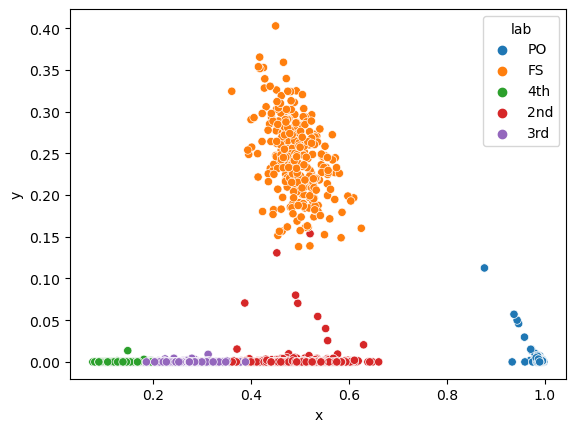

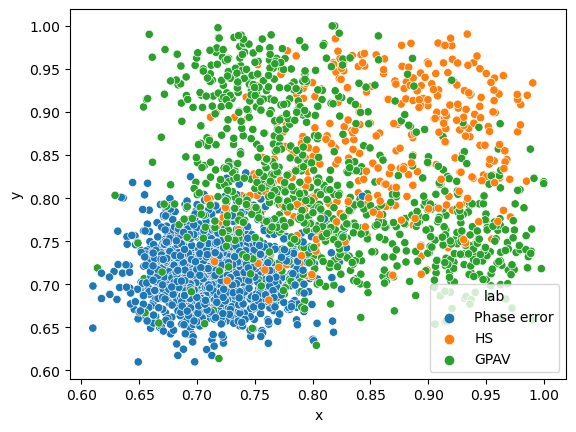

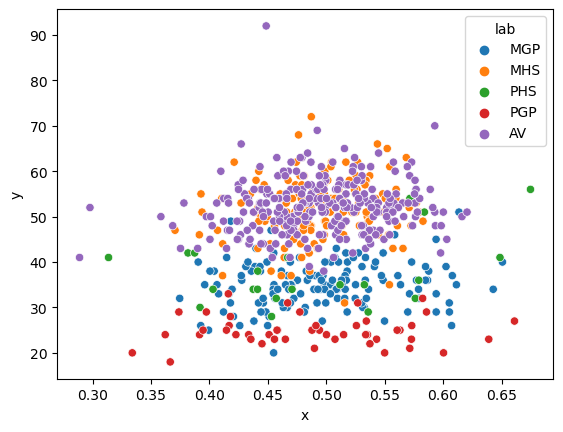

Trained degree classifier (2187 samples).
[[0.4114 0.    ]
 [0.452  0.    ]
 [0.5683 0.0043]
 ...
 [0.1547 0.    ]
 [0.1615 0.    ]
 [0.9897 0.002 ]]


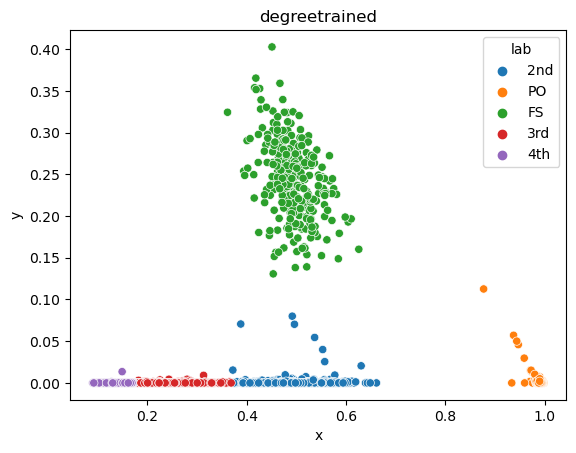

	Performed leave-one-out x-validation for 2187 samples (5.01 seconds).
Trained no. of segments classifier (638 samples).
[[ 0.4114 44.    ]
 [ 0.452  44.    ]
 [ 0.5726 48.    ]
 ...
 [ 0.498  53.    ]
 [ 0.6205 51.    ]
 [ 0.4738 56.    ]]


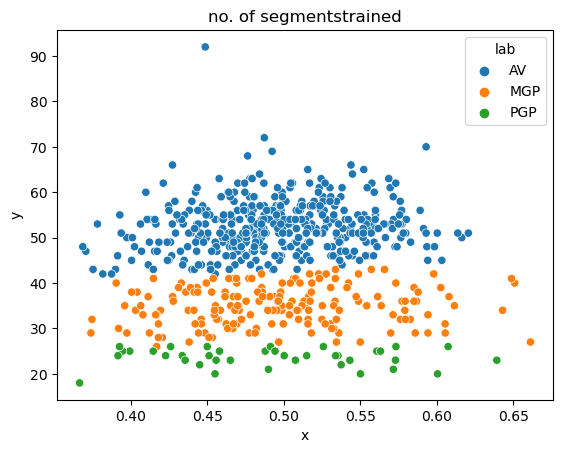

	Performed leave-one-out x-validation for 638 samples (0.53 seconds).
Trained haplotype classifier (638 samples).
[[0.7959635  0.83084241]
 [0.79172352 0.92738051]
 [0.83009632 0.92841021]
 ...
 [0.87227811 0.85503842]
 [0.77950197 0.72633782]
 [0.80080613 0.76903642]]


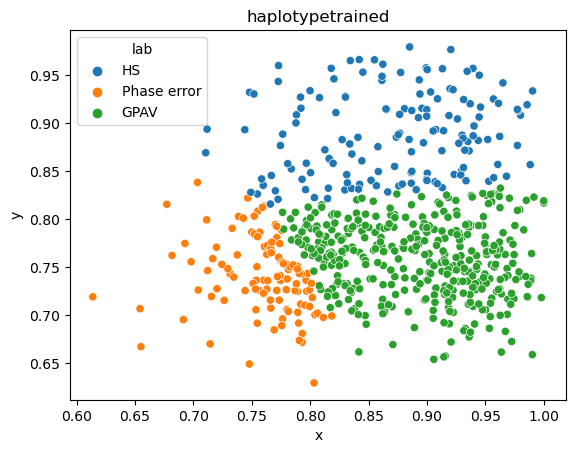

	Performed leave-one-out x-validation for 638 samples (0.53 seconds).


NameError: name 'args' is not defined

In [ ]:
degree_classif, hap_classif, n_classif = trainClassifiers(pairs)

# get data frame of the unknown 
unknown_df = samples.to_dataframe([], include_edges=False)
unknown_df = unknown_df[unknown_df.k_degree!="UN"].reset_index(drop=True)
unknown_df["ibd_cov"] = unknown_df.apply(lambda x: x.ibd1 + x.ibd2, axis=1)

# get the degree probabilities
probs, labels = degree_classif.predict_proba(X=unknown_df[["k_ibd1", "k_ibd2"]].values,
                                            ids=unknown_df[["id1", "id2"]].values)

# add the probabilities to the tree
for (_, row), prob in zip(unknown_df.iterrows(), probs):
    row["probs"].add_probs(list(zip(labels, prob)), "ibd")

# subset to second degree relatives
second_df = unknown_df[unknown_df["probs"].apply(lambda x: x.hier.nodes["2nd"]["p_con"] > 0.2)]

# get the n_ibd segs classifier probabilities
probs, labels = n_classif.predict_proba(X=second_df[["ibd_cov", "n"]].values,
                                        ids=second_df[["id1", "id2"]].values)
# add the probabilities to the tree
for (_, row), prob in zip(second_df.iterrows(), probs):
    row["probs"].add_probs(list(zip(labels, prob)), "nsegs")

    # for each of these nodes, take the sum of the two children
    for node in ["GP", "GPAV", "HS"]:
        # array of the children probabilities
        child_probs = [row["probs"].hier.nodes[i]["p_con"] for i in row["probs"].hier.successors(node)]
        # add the probability
        row["probs"].add_probs(node, p_con=sum(child_probs), method="nsegs")


# get the probabilities from the hap score classifier
probs, labels = hap_classif.predict_proba(X=np.array(second_df.apply(lambda x: sorted([h for _,h in x.h.items()], reverse=True), axis=1).values.tolist()),
                                            ids=second_df[["id1", "id2"]].values)

for (_, row), prob in zip(second_df.iterrows(), probs):
    # get the index of the Phase error class
    classes = list(labels)
    pe_index = classes.index("Phase error"); del classes[pe_index]

    # the chance of high Phase error is high; do not update the HS or GPAV probabilities
    if prob[pe_index] < -1:
        row["probs"].add_probs(list(zip(classes, np.delete(prob, pe_index))), "hap")

# merge the second degree back in with the unknowns
unknown_df = pd.concat([unknown_df, second_df]).drop_duplicates(subset=["id1", "id2"], keep="last").reset_index(drop=True)

samples.edge_subset(unknown_df[["id1", "id2"]].apply(lambda x: tuple(x), axis=1).values, inplace=True)

relatives_obj = ResultsData(samples=samples,
                            pairs=pairs,
                            classifiers=[degree_classif, hap_classif, n_classif],
                            df=unknown_df)
relatives_obj.compute_probs()
relatives_obj.set_min_probability(args.min_p)


In [ ]:
second_df["probs"].apply(lambda x: x.hier.nodes["HS"]["p"])

0       0.364482
1       0.363784
2       0.395203
3       0.374144
5       0.343767
          ...   
2876    0.368754
2877    0.384898
2885    0.377422
2888    0.417118
2899    0.360428
Name: probs, Length: 775, dtype: float64

In [ ]:
df = relatives_obj.pairs.get_pair_df_from(["HS", "AV", "GP"]).rename({"requested": "true"}, axis=1)
tmp_df = relatives_obj.to_dataframe(df["pair"].values, include_edges=True)
tmp_df["predicted"] = relatives_obj.most_likely_among(tmp_df, nodes=["HS", "AV", "GP"])
tmp_df["pair"] = tmp_df.apply(lambda x: tuple(sorted([x.id1, x.id2])), axis=1)
a = df[["pair", "true"]].merge(tmp_df[["pair", "predicted"]], on="pair")


In [ ]:
tmp_df["max_p"] = tmp_df["probs"].apply(lambda x: max([x.hier.nodes[i]["p"] for i in ["HS", "GP", "AV"]]))
tmp_df["pair"] = tmp_df.apply(lambda x: tuple(sorted([x.id1, x.id2])), axis=1)
tmp = df[["pair", "true"]].merge(tmp_df[["pair", "predicted","max_p"]], on="pair")
tmp["correct"] = tmp["true"]==tmp["predicted"]
tmp["top2"] = tmp_df["probs"].apply(lambda x: x.top2(["HS", "GP", "AV"]))
tmp["correct2"] = tmp.apply(lambda x: x.true in x.top2, axis=1)

# sns.boxplot(data=tmp, x="correct", y="max_p")

tmp["correct2"].mean()
# sns.histplot(data=tmp_df, x="max_p", hue="predicted")

0.7601078167115903

In [ ]:
a

NameError: name 'a' is not defined

In [ ]:
hap_classif.

/var/folders/73/bvswjwr972z7v296rcflvwc40000gn/T/ipykernel_55879/1710328472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["h1"] = tmp["h"].apply(lambda x: min([j for _,j in x.items()]))
/var/folders/73/bvswjwr972z7v296rcflvwc40000gn/T/ipykernel_55879/1710328472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["h2"] = tmp["h"].apply(lambda x: max([j for _,j in x.items()]))
/var/folders/73/bvswjwr972z7v296rcflvwc40000gn/T/ipykernel_55879/1710328472.py:5: SettingWithCopyWarning: 
A value is tr

<Axes: xlabel='h1', ylabel='h2'>

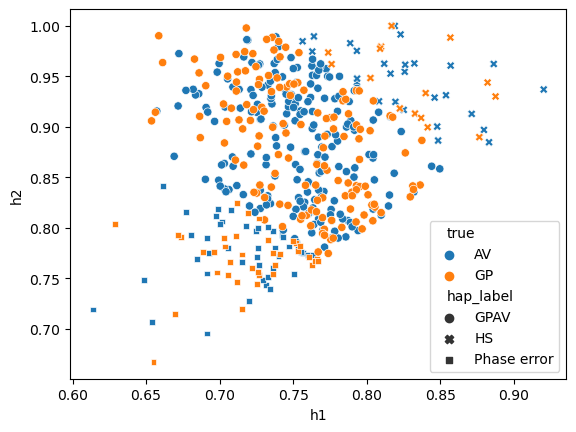

In [ ]:
tmp = df.dropna()
tmp["h1"] = tmp["h"].apply(lambda x: min([j for _,j in x.items()]))
tmp["h2"] = tmp["h"].apply(lambda x: max([j for _,j in x.items()]))

tmp["hsr"] = tmp["h"].apply(lambda x: min([j for _,j in x.items()])/max([j for _,j in x.items()]))
tmp["hap_label"] = hap_classif.lda.predict(tmp[["h1", "h2"]].values)
tmp["hap_p"] = [max(i) for i in hap_classif.lda.predict_proba(tmp[["h1", "h2"]].values)]

sns.scatterplot(data=tmp[tmp.true.isin(["AV", "GP"])], x="h1", y="h2", hue="true", style="hap_label")

<Axes: xlabel='h1', ylabel='h2'>

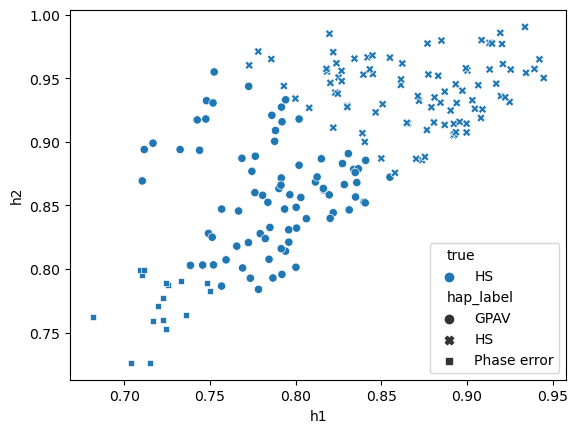

In [ ]:
sns.scatterplot(data=tmp[tmp.true.isin(["HS"])], x="h1", y="h2", hue="true", style="hap_label")

In [410]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import networkx as nx
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools as it
import matplotlib as mpl
import subprocess
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from pedigree_tools import introduce_phase_error, ProcessSegments, PedigreeHierarchy, Pedigree, visualize_classifiers
from Ponderosa import SampleData, ResultsData
from matplotlib import colors


# Takes in a results data frame and a list of nodes and returns samples that are classified as one of the nodes and then the most likely relationship among the nodes
def performance_df(results, nodes, king, ersa, degree=True):
    # get a dataframe of the nodes
    known_pairs = results.pairs.get_pair_df_from(nodes).dropna(subset=["k_ibd1"])

    known_pairs = known_pairs.rename({"requested": "true"}, axis=1)

    # get the probability hierarchy
    known_pairs["probs"] = known_pairs["pair"].apply(lambda x: results.samples.g.get_edge_data(*x).get("probs", np.nan))

    # drop samples that don't have a pedigree hierarchy
    known_pairs = known_pairs.dropna(subset=["probs"])

    # get the most likely relationship among the nodes
    known_pairs["PONDEROSA"] = known_pairs["probs"].apply(lambda x: x.most_likely_among(nodes))

    algorithms = ["PONDEROSA"]

    if king:
        known_pairs["KING"] = known_pairs["pair"].apply(lambda x: results.samples.g.get_edge_data(*x)["k_degree"])
        algorithms.append("KING")

    if ersa:        
        known_pairs["ERSA"] = known_pairs["pair"].apply(lambda x: results.samples.g.get_edge_data(*x).get("e_degree" if degree else "e_rel", np.nan))
        algorithms.append("ERSA")

    return pd.melt(known_pairs.dropna(subset=algorithms)[["pair", "true"] + algorithms], id_vars=["pair", "true"], value_vars=algorithms, var_name="algorithm", value_name="predicted")


def facetgrid_ready(df, labels):
    data = []
    for group, group_df in df.groupby("algorithm"):
        for lab1 in labels:
            true = group_df[group_df.true==lab1]
            for lab2 in labels:
                correct = true[true.predicted==lab2]
                p = correct.shape[0] / true.shape[0] if true.shape[0] > 0 else 0
                data.append([group, lab1, lab2, p, true.shape[0]])
    tmp = pd.DataFrame(data, columns=["algorithm", "true", "predicted", "correct", "n"])
    tmp.true = pd.Categorical(tmp.true, ordered=True, categories=labels)
    tmp.predicted = pd.Categorical(tmp.predicted, ordered=True, categories=labels)
    return tmp

def plot_R(df, output):
    df_string = df.to_string(index=False)
    subprocess.call(f"Rscript ../Ponderosa_manuscript/plots.R <(echo -e '{df_string}') {output}", shell=True, executable="/bin/bash")


def precision_recall(df, nodes, title):
    tmp = []
    for alg, alg_df in df.groupby("algorithm"):
        mat = confusion_matrix(alg_df["true"], alg_df["predicted"], labels=nodes)
        for index, rel in enumerate(nodes):
            tmp.append([alg, rel, mat[index, index]/mat[:, index].sum(), "precision", title])
            tmp.append([alg, rel, mat[index,index]/mat[index,:].sum(), "recall", title])
    return pd.DataFrame(tmp, columns=["algorithm", "relationship", "stat", "precision_recall", "title"])

a["algorithm"] = "PONDEROSA"
plot_R(facetgrid_ready(a[["predicted", "true", "algorithm"]], ["HS", "AV", "GP"]), "../../../Desktop/bags.png")

Warning message:
In file(file, "rt") :
  using 'raw = TRUE' because '/dev/fd/63' is a fifo or pipe
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [347]:
a

,pair,true,predicted,algorithm
0,"(15254001, 15254050)",HS,HS,PONDEROSA
1,"(15022035, 15022039)",HS,HS,PONDEROSA
2,"(15108050, 15108051)",HS,AV,PONDEROSA
3,"(15003008, 15003015)",HS,AV,PONDEROSA
4,"(15022035, 15022038)",HS,HS,PONDEROSA
...,...,...,...,...
366,"(15031001, 15031010)",GP,GP,PONDEROSA
367,"(15018003, 15018007)",GP,GP,PONDEROSA
368,"(15537007, 15537012)",GP,HS,PONDEROSA
369,"(15031046, 15031054)",GP,HS,PONDEROSA


In [3]:
obj.pairs.get_pair_df_from(["MHS", "PHS"])

,pair,degree,rel,k_ibd1,k_ibd2,h,h_error,n,ibd1,ibd2,mat,requested
0,"(HMB117, HMB521)",2nd,MHS,0.5624,0.0154,"{'HMB117': 0.9648780652699438, 'HMB521': 0.940...","{'HMB117': 0.7416578133433649, 'HMB521': 0.697...",67,0.5,0.0,"[[2, 1, -1]]",MHS
1,"(HMB039, HMB775)",2nd,MHS,0.5482,0.0030,"{'HMB039': 0.9546453080461378, 'HMB775': 0.973...","{'HMB039': 0.7182181685808703, 'HMB775': 0.737...",65,0.5,0.0,"[[2, 1, -1]]",MHS
2,"(HMB065, HMB391)",2nd,MHS,0.6105,0.0182,"{'HMB065': 0.9564938472067457, 'HMB391': 0.953...","{'HMB065': 0.7767828454266948, 'HMB391': 0.704...",60,0.5,0.0,"[[2, 1, -1]]",MHS
3,"(HMB2174, HMB2176)",2nd,MHS,0.5550,0.0143,"{'HMB2174': 0.8854738758575352, 'HMB2176': 0.9...","{'HMB2174': 0.7200195994508953, 'HMB2176': 0.7...",69,0.5,0.0,"[[2, 1, -1]]",MHS
4,"(HMB302, HMB678)",2nd,MHS,0.5700,0.0086,"{'HMB302': 0.9592771671673616, 'HMB678': 0.885...","{'HMB302': 0.7316615615442293, 'HMB678': 0.678...",68,0.5,0.0,"[[2, 1, -1]]",MHS
...,...,...,...,...,...,...,...,...,...,...,...,...
819,"(HMB2157, HMB989)",2nd,PHS,0.4773,0.0051,"{'HMB2157': 0.9606210894853289, 'HMB989': 0.91...","{'HMB2157': 0.7278478715324108, 'HMB989': 0.73...",51,0.5,0.0,"[[1, 1, -1]]",PHS
820,"(HMB1035, HMB2233)",2nd,PHS,0.5027,0.0096,"{'HMB1035': 0.9808271570030996, 'HMB2233': 0.9...","{'HMB1035': 0.7433406547975231, 'HMB2233': 0.7...",45,0.5,0.0,"[[1, 1, -1]]",PHS
821,"(HMB037, HMB359)",2nd,PHS,0.5288,0.0108,"{'HMB037': 0.9495920195983139, 'HMB359': 0.942...","{'HMB037': 0.699223608928818, 'HMB359': 0.7022...",46,0.5,0.0,"[[1, 1, -1]]",PHS
822,"(HMB120, HMB840)",2nd,PHS,0.6098,0.0068,"{'HMB120': 0.8925126773777473, 'HMB840': 0.945...","{'HMB120': 0.6863969384535037, 'HMB840': 0.714...",47,0.5,0.0,"[[1, 1, -1]]",PHS


In [7]:
obj.samples.g["HMB780"]["HMB934"]["probs"].top2(["MHS","PHS", "AV", "GP"])

['PHS', 'MHS']

In [29]:
import heapq


nodes = ["apple", "banana", "cherry", "date"]
ps = [5, 3, 1, 4]
combined_data = zip(ps, nodes)  

heapq.nlargest(2, combined_data)

[(5, 'apple'), (4, 'date')]

In [2]:
i = open("for_dev/sample.pkl", "rb")
samples = pkl.load(i)
samples

In [3]:
pedigree = Pedigree(samples=samples, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pairs = pedigree.find_all_relationships()

# trains the classifiers
degree_classif, hap_classif, n_classif = trainClassifiers(pairs)

degree_classif.train_ids

unknown_df = samples.to_dataframe([], include_edges=False).reset_index(drop=True)
unknown_df = unknown_df[unknown_df.k_degree!="UN"].reset_index(drop=True)
unknown_df["ibd_cov"] = unknown_df.apply(lambda x: x.ibd1 + x.ibd2, axis=1)



In [421]:
tmp = pd.DataFrame({"predicted":hap_classif.lda.predict(hap_classif.X), "true":hap_classif.y})
tmp = tmp[tmp.true!="Phase error"]

print(Counter(tmp[tmp.true=="HS"]["predicted"]))
Counter(tmp[tmp.true=="GPAV"]["predicted"])


Counter({'HS': 178, 'GPAV': 160, 'Phase error': 34})


Counter({'GPAV': 676, 'Phase error': 160, 'HS': 84})

In [5]:
a, lab = degree_classif.predict_proba(unknown_df[["k_ibd1", "k_ibd2"]].values, unknown_df[["id1", "id2"]].values)

[    0     1     2 ... 83586 83587 83588]
[   14    32    89 ... 83538 83565 83572] [    0     1     2 ... 83586 83587 83588]
Trained degree classifier (4805 samples).
	Performed leave-one-out x-validation for 4805 samples (24.88 seconds).


In [6]:

# add the probabilities to the tree
for (_, row), prob in zip(unknown_df.iterrows(), a):
    row["probs"].add_probs(list(zip(lab, prob)), "ibd")

In [7]:
second_df = unknown_df[unknown_df["probs"].apply(lambda x: x.hier.nodes["2nd"]["p_con"] > 0.2)]

In [172]:
i = open("/Users/cwilli50/Downloads/ponderosa_output/all_chr_no_discord/bags_wgs_no_discord_results.pkl", "rb")
obj = pkl.load(i)
dir(obj)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'compute_probs',
 'df',
 'most_likely_among',
 'pairs',
 'pickle_it',
 'samples',
 'set_min_probability',
 'subset_dataframe',
 'subset_samples',
 'to_dataframe',
 'write_readable']

In [8]:
# get the n_ibd segs classifier probabilities
probs, labels = n_classif.predict_proba(X=second_df[["ibd_cov", "n"]].values,
                                        ids=second_df[["id1", "id2"]].values)
# add the probabilities to the tree
for (_, row), prob in zip(second_df.iterrows(), probs):
    row["probs"].add_probs(list(zip(labels, prob)), "nsegs")

    # for each of these nodes, take the sum of the two children
    for node in ["GP", "GPAV", "HS"]:
        # array of the children probabilities
        child_probs = [row["probs"].hier.nodes[i]["p_con"] for i in row["probs"].hier.successors(node)]
        # add the probability
        row["probs"].add_probs(node, p_con=sum(child_probs), method="nsegs")


# get the probabilities from the hap score classifier
probs, labels = hap_classif.predict_proba(X=second_df.apply(lambda x: sorted([h for _,h in x.h.items()], reverse=True), axis=1).values,
                                            ids=second_df[["id1", "id2"]].values)

for (_, row), prob in zip(second_df.iterrows(), probs):
    # get the index of the Phase error class
    classes = list(labels)
    pe_index = classes.index("Phase error"); del classes[pe_index]

    # the chance of high Phase error is high; do not update the HS or GPAV probabilities
    if prob[pe_index] < 0.2:
        row["probs"].add_probs(list(zip(classes, np.delete(prob, pe_index))), "hap")


[   0    1    9   27   29   30   32   37   38   39   54   56   66   70
   73   74   75   76   77   78   90   91   98   99  101  102  106  117
  118  119  120  130  134  136  145  151  157  158  159  162  165  166
  167  168  169  175  176  177  178  181  198  199  204  207  208  209
  212  214  226  227  228  229  230  231  232  233  234  240  247  248
  249  256  260  263  264  269  270  271  274  277  278  280  297  300
  301  302  303  317  333  342  344  355  357  370  374  375  385  386
  387  391  392  393  394  397  402  403  408  415  416  421  422  429
  433  440  441  444  445  447  448  449  453  454  455  458  459  460
  461  464  465  466  467  468  479  480  481  482  483  484  485  488
  489  490  491  492  493  497  499  508  512  515  517  518  519  520
  535  539  540  541  542  550  552  553  570  585  592  593  594  595
  596  597  605  614  642  655  665  666  667  668  670  671  672  673
  686  687  695  699  704  707  716  717  718  719  720  721  722  723
  724 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [40]:
degree_classif.y[np.where(degree_classif.train_ids=="HMB1079_HMB2161")[0][0]]

'PO'

In [30]:
np.array(second_df.apply(lambda x: sorted([h for _,h in x.h.items()], reverse=True), axis=1).values.tolist()).shape

(1996, 2)

In [31]:
second_df

,id1,id2,n,h,k_prop,h_error,k_degree,probs,k_ibd2,ibd2,k_ibd1,ibd1,ibd_cov
23,HMB001,HMB062,67.0,"{'HMB001': 0.9208475806308343, 'HMB062': 0.948...",0.2799,"{'HMB001': 0.7377547996097301, 'HMB062': 0.727...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0089,0.013090,0.5420,0.547226,0.560315
118,HMB001,HMB1042,42.0,"{'HMB001': 0.768509299576988, 'HMB1042': 0.943...",0.2452,"{'HMB001': 0.6641903320539397, 'HMB1042': 0.68...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0000,0.004122,0.4904,0.480380,0.484501
133,HMB001,HMB2101,48.0,"{'HMB001': 0.8373351757084773, 'HMB2101': 0.93...",0.2100,"{'HMB001': 0.732234530525111, 'HMB2101': 0.779...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0055,0.008050,0.4089,0.425574,0.433623
134,HMB001,HMB2102,36.0,"{'HMB001': 0.8252182239576669, 'HMB2102': 0.98...",0.2418,"{'HMB001': 0.7201022247508043, 'HMB2102': 0.77...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0035,0.006474,0.4765,0.462045,0.468519
176,HMB001,HMB2978,30.0,"{'HMB001': 0.8500717489025333, 'HMB2978': 0.98...",0.3432,"{'HMB001': 0.7092987049102335, 'HMB2978': 0.74...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0060,0.005297,0.6743,0.654965,0.660262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83493,HMB4022,HMB5192,67.0,"{'HMB4022': 0.7486081046623974, 'HMB5192': 0.8...",0.2709,"{'HMB4022': 0.7262312735543294, 'HMB5192': 0.7...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0052,0.005156,0.5315,0.526706,0.531862
83508,HMB5058,HMB5085,65.0,"{'HMB5058': 0.9080153131774504, 'HMB5085': 0.8...",0.2793,"{'HMB5058': 0.7472342902244942, 'HMB5085': 0.7...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0185,0.015617,0.5216,0.493200,0.508817
83538,HMB5093,HMB5183,66.0,"{'HMB5093': 0.9324384062081538, 'HMB5183': 0.9...",0.3120,"{'HMB5093': 0.760357557168993, 'HMB5183': 0.71...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0241,0.024003,0.5758,0.564980,0.588984
83573,HMB5237,HMB5239,57.0,"{'HMB5237': 0.9686554568849582, 'HMB5239': 0.9...",0.3004,"{'HMB5237': 0.7151420812416688, 'HMB5239': 0.6...",2nd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.0068,0.008900,0.5872,0.584734,0.593634


In [82]:
tmp = obj.samples.to_dataframe([], False)
tmp[tmp.apply(lambda x: x.id1==15018005 and x.id2==15018006, axis=1)]

,id1,id2,k_prop,n,h,h_error,ibd2,k_ibd2,ibd1,k_degree,probs,k_ibd1


In [18]:
pedigree = Pedigree(samples=obj.samples, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")



In [19]:
sib_pairs = set(it.chain(*[[tuple(sorted([id1, id2])) for id1, id2 in it.combinations(pedigree.po.successors(node), r=2)] for node in pedigree.po.nodes]))

sib_pairs |= {tuple(sorted([id1, id2])) for id1, id2 in pedigree.samples.get_edges(lambda x: x["k_degree"]=="FS")}

sib_df = pedigree.samples.to_dataframe(sib_pairs, include_edges=True)

sib_df

,id1,id2,h,k_prop,k_ibd2,ibd1,k_ibd1,k_degree,ibd2,n,h_error,probs
0,15022048,15022057,"{'15022057': 0.7610099840563003, '15022048': 0...",0.4533,0.1522,0.577065,0.6021,FS,0.150297,46,"{'15022057': 0.683345275842568, '15022048': 0....",<pedigree_tools.PedigreeHierarchy object at 0x...


In [30]:
obj.samples.g.get_edge_data("15553004", "15553005")

In [28]:
obj.samples.g.get_edge_data("15022048", "15022057")

{'k_prop': 0.4533,
 'k_ibd1': 0.6021,
 'k_ibd2': 0.1522,
 'k_degree': 'FS',
 'probs': <pedigree_tools.PedigreeHierarchy at 0x2c2adf290>,
 'ibd1': 0.5770650885757067,
 'ibd2': 0.15029654683834223,
 'h': {'15022057': 0.7610099840563003, '15022048': 0.8315812309926686},
 'h_error': {'15022057': 0.683345275842568, '15022048': 0.69166056958237},
 'n': 46}

In [150]:
class Classifier:
    def __init__(self, X, y, ids):

        self.lda = LinearDiscriminantAnalysis().fit(X, y)
        self.train_ids = np.array(ids)
        self.X = X; self.y = y

    def loo(self, ids):
        proba_arr = []

        # iterate through the training pairs
        for id1 in ids:
            lda = LinearDiscriminantAnalysis().fit(self.X[np.where(self.train_ids!=id1)[0],:],
                                                   self.y[np.where(self.train_ids!=id1)[0]])
            # get proba
            proba = lda.predict_proba(self.X[np.where(self.train_ids==id1)[0]])
            proba_arr.append(proba[0])
        
        return np.array(proba_arr)

    def predict_proba(self, X, ids):
        # index of the training data versus the test data
        train_idx = np.where(np.in1d(ids, self.train_ids))[0]
        test_idx = np.where(~np.in1d(ids, self.train_ids))[0]

        # get the probabilities from the fully trained index
        test_proba = self.lda.predict_proba(X[test_idx, :])
        train_proba = self.loo(ids[train_idx])

        # concat proba
        proba = np.concatenate((test_proba, train_proba))

        # reorder the proba matrix to match the order of the ids
        return proba[np.where(ids[np.concatenate((test_idx, train_idx))]==ids[:, np.newaxis])[1], :]
    
classif = Classifier(np.array([[0, 0.0], [0, 0.01], [0.125, 0.02], [0.125, 0], [0.25, 0.1], [0.25, 0], [0.50, 0], [0.50, 0.02]]),
                     np.array(["4th", "4th", "3rd", "3rd", "2nd", "2nd", "1st", "1st"]), np.array(["A1", "A2", "B1", "B2", "C1", "C2", "D1", "D2"]))

a = classif.predict_proba(np.array([[0, 0.0], [0.125, 0.0], [0.50, 0]]), np.array(["A1", "B2", "E1"]))


In [149]:
X, y, l = [], [], []
for (i,j), k in zip([[0,.1], [.125, 0], [.25, .1], [.5, .25]], ["5th", "4th", "3rd", "2nd"]):
    X += list(np.random.multivariate_normal([i*100,j*100], [[0.1,0.01],[0.1,0.01]], 10))
    y += [k]*10
    l += [f"{k}_{i}" for i in range(1, 11)]

X = np.array(X)
y = np.array(y)
l = np.array(l)

classif = Classifier(X, y, l)

classif.predict_proba(np.append(X, [[25, 10]], axis=0), np.append(l, ["test"]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] [40]
['test'] [[25. 10.]]
['3rd' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '4th'
 '4th' '4th' '4th' '4th' '4th' '4th' '4th' '4th' '4th' '3rd' '3rd' '3rd'
 '3rd' '3rd' '3rd' '3rd' '3rd' '3rd' '3rd' '2nd' '2nd' '2nd' '2nd' '2nd'
 '2nd' '2nd' '2nd' '2nd' '2nd']
['5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '5th' '4th' '4th'
 '4th' '4th' '4th' '4th' '4th' '4th' '4th' '4th' '3rd' '3rd' '3rd' '3rd'
 '3rd' '3rd' '3rd' '3rd' '3rd' '3rd' '2nd' '2nd' '2nd' '2nd' '2nd' '2nd'
 '2nd' '2nd' '2nd' '2nd' '3rd']


/var/folders/73/bvswjwr972z7v296rcflvwc40000gn/T/ipykernel_77947/24418435.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X += list(np.random.multivariate_normal([i*100,j*100], [[0.1,0.01],[0.1,0.01]], 10))


array([[0.00000000e+000, 1.84150950e-161, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 5.69553307e-173, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 9.89726386e-176, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 2.19127576e-179, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 1.55260393e-184, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 3.26094012e-164, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 8.59035736e-167, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 1.95902637e-181, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 4.49932245e-161, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 5.34639809e-192, 0.00000000e+000,
        1.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
      

In [171]:
np.random.shuffle(y)
lda = LinearDiscriminantAnalysis().fit(X, y)
lda.classes_

array(['2nd', '3rd', '4th', '5th'], dtype='<U3')

In [156]:
np.random.shuffle(y)
y

array(['3rd', '3rd', '3rd', '5th', '3rd', '5th', '2nd', '4th', '2nd',
       '2nd', '5th', '5th', '3rd', '4th', '2nd', '5th', '2nd', '4th',
       '4th', '4th', '2nd', '2nd', '2nd', '4th', '4th', '3rd', '4th',
       '2nd', '5th', '2nd', '3rd', '3rd', '3rd', '4th', '3rd', '5th',
       '5th', '4th', '5th', '5th'], dtype='<U3')

array(['3rd'], dtype='<U3')

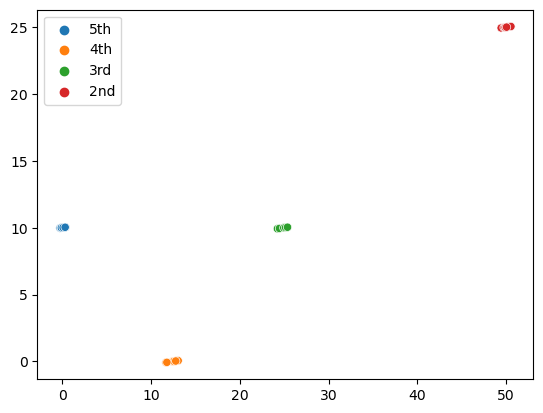

In [138]:
y_pred = classif.lda.predict(X)
sns.scatterplot(x=X[:,0],y=X[:,1], hue=y_pred)
classif.lda.predict([[25, 10]])


In [148]:
len(l)

36

<Axes: >

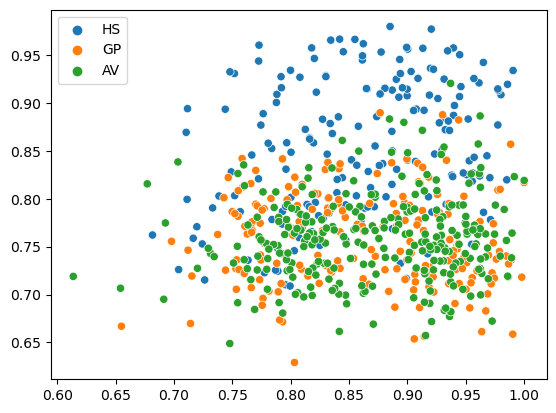

In [75]:
x = df.apply(lambda x: x.h[x.pair[0]],axis=1).values
y = df.apply(lambda x: x.h[x.pair[1]],axis=1).values
rel = df.requested.values

sns.scatterplot(x=x, y=y, hue=rel)

In [54]:
pedigree = Pedigree(samples=obj.samples, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pedigree.find_all_relationships()

ValueError: Found array with 1 sample(s) (shape=(1, 2)) while a minimum of 2 is required by GaussianMixture.

In [61]:
obj.to_dataframe([], False).dropna(subset="n")

,id1,id2,k_prop,n,h,h_error,ibd2,k_ibd2,ibd1,k_degree,probs,k_ibd1
329,15002002,15532001,0.1494,48.0,"{'15532001': 0.7945412523296065, '15002002': 0...","{'15532001': 0.7369809642342189, '15002002': 0...",0.000000,0.0000,0.322964,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2989
350,15002002,15002013,0.1283,41.0,"{'15002002': 0.9063430583314667, '15002013': 0...","{'15002002': 0.7818981909065768, '15002013': 0...",0.000000,0.0000,0.243760,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2566
360,15002003,15532001,0.1368,42.0,"{'15532001': 0.8074361362310483, '15002003': 0...","{'15532001': 0.8245545951457476, '15002003': 0...",0.000000,0.0000,0.269853,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2736
387,15002003,15002013,0.1410,37.0,"{'15002003': 0.9096932415868142, '15002013': 0...","{'15002003': 0.7400732422287393, '15002013': 0...",0.000000,0.0000,0.266574,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2820
401,15002004,15532016,0.1011,30.0,"{'15532016': 0.9236966202853334, '15002004': 0...","{'15532016': 0.7607246954090208, '15002004': 0...",0.002016,0.0028,0.203189,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.1965
...,...,...,...,...,...,...,...,...,...,...,...,...
21088,15558004,15558014,0.1212,44.0,"{'15558004': 0.914479387808402, '15558014': 0....","{'15558004': 0.8196303055171443, '15558014': 0...",0.000000,0.0000,0.258902,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2423
21090,15558005,15558012,0.1381,30.0,"{'15558012': 0.9525293158940699, '15558005': 0...","{'15558012': 0.7873937178952394, '15558005': 0...",0.000000,0.0000,0.256812,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2762
21092,15558005,15558009,0.1274,37.0,"{'15558005': 0.8951899026735328, '15558009': 0...","{'15558005': 0.8070561593640406, '15558009': 0...",0.000000,0.0000,0.260733,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2547
21093,15558005,15558014,0.1347,50.0,"{'15558005': 0.8711406817746764, '15558014': 0...","{'15558005': 0.7641678001895895, '15558014': 0...",0.002026,0.0000,0.266316,3rd,<pedigree_tools.PedigreeHierarchy object at 0x...,0.2694


In [52]:
i = open("for_dev/Ponderosa_results.pkl", "rb")
results = pkl.load(i)

In [46]:
i = open("for_dev/Ponderosa_samples.pkl", "rb")
samples = pkl.load(i)

In [51]:
pedigree = Pedigree(samples=samples, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pedigree.find_all_relationships()

pairs = pedigree.hier

known = pairs.get_pair_df("relatives")[["pair", "degree", "rel", "k_ibd1", "k_ibd2"]]


In [62]:
results.to_dataframe([], False, True)
results.write_readable("for_dev/Ponderosa_readable.txt")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/cwilli50/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/73/bvswjwr972z7v296rcflvwc40000gn/T/ipykernel_7557/853783331.py", line 2, in <module>
    results.write_readable("for_dev/Ponderosa_readable.txt")
  File "/Users/cwilli50/Desktop/projects/Ponderosa-beta/Ponderosa.py", line 374, in write_readable
  File "/Users/cwilli50/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py", line 3767, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cwilli50/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 5877, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/Users/cwilli50/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 59

In [70]:
results.write_readable("for_dev/Ponderosa_readable.txt", columns = ["id1", "id2", "degree", "k_ibd1", "k_ibd2"])

In [71]:
unknown = pd.read_csv("for_dev/Ponderosa_readable.txt", sep="\t")
unknown

,id1,id2,degree,k_ibd1,k_ibd2
0,HMB001,HMB002,4th,0.0823,0.0000
1,HMB001,HMB003,3rd,0.2572,0.0000
2,HMB001,HMB004,4th,0.0815,0.0000
3,HMB001,HMB005,4th,0.1138,0.0000
4,HMB001,HMB006,4th,0.0570,0.0000
...,...,...,...,...,...
216824,HMB5273,HMB5278,4th,0.1122,0.0000
216825,HMB5273,HMB5279,4th,0.0598,0.0000
216826,HMB5275,HMB5278,4th,0.0971,0.0013
216827,HMB5275,HMB5279,4th,0.0855,0.0000


In [73]:
known["id1"] = known["pair"].apply(lambda x: x[0])
known["id2"] = known["pair"].apply(lambda x: x[1])
known


,pair,degree,rel,k_ibd1,k_ibd2,id1,id2
0,"(HMB779, HMB122)",3rd,HAV,0.2888,0.0000,HMB779,HMB122
1,"(HMB2094, HMB413)",2nd,MHS,0.5707,0.0022,HMB2094,HMB413
2,"(HMB2298, HMB3045)",FS,FS,0.6060,0.1846,HMB2298,HMB3045
3,"(HMB866, HMB3054)",3rd,HAV,0.2699,0.0012,HMB866,HMB3054
4,"(HMB3022, HMB059)",3rd,GGP,0.2793,0.0104,HMB3022,HMB059
...,...,...,...,...,...,...,...
5196,"(HMB015, HMB937)",FS,FS,0.4873,0.1983,HMB015,HMB937
5197,"(HMB2297, HMB5141)",2nd,MHS,0.5231,0.0000,HMB2297,HMB5141
5198,"(HMB2968, HMB978)",2nd,MGP,0.4559,0.0122,HMB2968,HMB978
5199,"(HMB1038, HMB307)",PO,PO,0.9804,0.0163,HMB1038,HMB307


In [76]:
known["known"] = 1
unknown["known"] = 0

pairs = pd.concat([known[["id1", "id2", "k_ibd1", "k_ibd2", "degree", "known"]], unknown])

<Axes: xlabel='k_ibd1', ylabel='k_ibd2'>

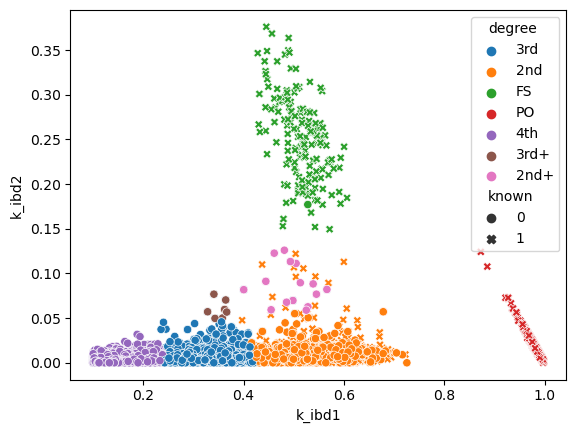

In [83]:
sns.scatterplot(data=pairs[pairs.k_ibd1>0.1], x="k_ibd1", y="k_ibd2", hue="degree", style="known")

In [82]:
pairs[pairs.k_ibd1>0.1].reset_index(drop=True).to_csv("/Users/cwilli50/Downloads/Himba_degrees.csv", index=False)

In [77]:
pair_list = pairs[["id1", "id2"]].apply(tuple, axis=1).values.tolist()

In [78]:
("HMB060", "HMB3041") in pair_list

True

In [79]:
missing = pd.read_csv("/Users/cwilli50/Downloads/high_IBD_no_relation.csv")
for _, row in missing.iterrows():
    id1 = row["ego1"]; id2 = row["ego2"]
    if (id1, id2) in pair_list or (id2, id2) in pair_list:
        continue
    else:
        print(id1, id2)

    

In [43]:
tmp.iloc[0]["probs"].hier.nodes["GPAV"]

{'p': 0.994690129664906, 'p_con': 0.9946936398145334, 'method': 'hap'}

In [17]:
hier = df[(df.id1=="HMB094")&(df.id2=="HMB1078")].squeeze()["probs"]

In [22]:
hier.hier.nodes["relatives"]

{'p': 1, 'p_con': 1, 'method': 'None'}

In [49]:
temp_segs = pd.concat([pd.read_feather(f"/Users/cole/Desktop/brown/ponderosa/phasedibd_segments/Himba_shapeit.chr{chrom}_segments.f") for chrom in range(1, 23)])

In [50]:
temp_segs["PAIR_ID"] = temp_segs.apply(lambda x: "_".join(sorted([x.id1, x.id2])), axis = 1)
pairs_df = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_pairs.txt", delim_whitespace = True)
pairs_df

,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE
0,HMB004_HMB856,HMB004,HMB856,True,0.5086,0.0032,0.2575,2nd,MHS,2nd
1,HMB004_HMB2970,HMB004,HMB2970,True,0.5057,0.0180,0.2709,2nd,MHS,2nd
2,HMB005_HMB699,HMB005,HMB699,True,0.4282,0.3466,0.5607,FS,FS,FS
3,HMB005_HMB013,HMB005,HMB013,True,0.5922,0.0177,0.3138,2nd,PHS,2nd
4,HMB005_HMB1037,HMB005,HMB1037,True,0.5585,0.0072,0.2864,2nd,PHS,2nd
...,...,...,...,...,...,...,...,...,...,...
5234,HMB169_HMB999,HMB999,HMB169,True,0.9667,0.0320,0.5153,PO,PO,PO
5235,HMB359_HMB999,HMB999,HMB359,True,0.9734,0.0252,0.5119,PO,PO,PO
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,GP,2nd
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,GP,2nd


In [51]:
himba_segs = temp_segs[temp_segs.PAIR_ID.isin(pairs_df[pairs_df.DEGREE == "2nd"]["PAIR_ID"])].reset_index(drop = True)



In [52]:
pair_data = {}
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")


for (id1, id2, pair_id), pair_df in himba_segs.groupby(["id1", "id2", "PAIR_ID"]):
    pair_df["l"] = pair_df["end_cm"] - pair_df["start_cm"]
    pair_data[pair_id] = p.pair_segments(id1, id2, pair_df, 10)
#     print(pairs_df[pairs_df.PAIR_ID == "_".join(sorted([id1, id2]))]["REL"].squeeze())

In [53]:
n = PedigreeNetwork("/Users/cole/Desktop/brown/ponderosa/Himba_no2278.fam")
for index, row in pairs_df.iterrows():
    if row["REL"] == "GP":
        id1, id2 = row["IID1"], row["IID2"]
        r = n.find_relationship(id1, id2)[3]
        if len(r) == 0:
            continue
        r = [i for i in r if "GP" in i][0]
        r = "MGP" if r[2] == "2" else "PGP"
        pairs_df.at[index, "REL"] = r
        

In [54]:
second_pairs = pairs_df[pairs_df.GTD & (pairs_df.DEGREE == "2nd")].copy()
second_pairs["n"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].n_segs, axis = 1)
for group, group_df in second_pairs.groupby("REL"):
    print(group, group_df["n"].mean(), group_df["n"].std(), group_df.shape)



AV 52.709030100334445 4.503423611423107 (299, 11)
GP 40.214285714285715 5.025757829247421 (14, 11)
MGP 42.27436823104693 4.449860775562042 (277, 11)
MHS 52.68867924528302 4.395598932711155 (424, 11)
PGP 36.03968253968254 4.757143333809977 (126, 11)
PHS 44.447688564476884 4.3205762104812155 (411, 11)


In [55]:
fam = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_no2278.fam", delim_whitespace = True, header = None, dtype = str)
fam.columns = ["FID", "IID", "Father", "Mother", "Sex", "Pheno"]
pedigree = nx.DiGraph()
pedigree.add_nodes_from([[row["IID"], dict(sex=row["Sex"])] for _, row in fam.iterrows()])
pedigree.add_edges_from([list(i) + [dict(dir="down")] for i in fam[fam.Father != "0"][["Father", "IID"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="down")] for i in fam[fam.Mother != "0"][["Mother", "IID"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="up")] for i in fam[fam.Father != "0"][["IID", "Father"]].values])
pedigree.add_edges_from([list(i) + [dict(dir="up")] for i in fam[fam.Mother != "0"][["IID", "Mother"]].values])


def annotate_path(path):
    down = False
    anno_path = []
    for index in range(len(path)-1):
        d = pedigree.get_edge_data(path[index], path[index+1])["dir"]
        down = down or d == "down"
        if down and d == "up":
            return []
        anno_path.append(d)
    return anno_path
    

In [56]:
paths = dict(nx.all_pairs_shortest_path(pedigree, 5))

In [57]:
rels = []
for id1 in paths:
    for id2 in paths[id1]:
        if id1 >= id2:
            continue
        path_list = [annotate_path(i) for i in nx.all_simple_paths(pedigree, source = id1, target = id2, cutoff = 5)]
        path_list = [tuple(i) for i in path_list if len(i) > 0 and i[0] == "up"]
        if len(path_list) == 0:
            continue
        rels.append([id1, id2, path_list])


In [58]:
rels = {"G"*i + "P": ["up" for _ in range(i+1)] for i in range(1, 5)}
rels["AV"] = ["up", "up", "down"]
rels["CO"] = ["up", "up", "down", "down"]
rels["sib"] = ["up", "down"]
rels["PO"] = ["up"]
rels = {tuple(j): i for i, j in rels.items()}


rel_dict = rels
rel_dict

{('up', 'up'): 'GP',
 ('up', 'up', 'up'): 'GGP',
 ('up', 'up', 'up', 'up'): 'GGGP',
 ('up', 'up', 'up', 'up', 'up'): 'GGGGP',
 ('up', 'up', 'down'): 'AV',
 ('up', 'up', 'down', 'down'): 'CO',
 ('up', 'down'): 'sib',
 ('up',): 'PO'}

In [59]:
def legit_path(dir_path):
    down = False
    for d in dir_path:
        down = down or d == "down"
        if down and d == "up":
            return False
    return True

'''Path dir can be up...up, down...down, down...up, or up...down'''
def reverse_path(id1, id2, path, path_dir):
    # id1 is the genetically older individual
    if path_dir.count("down") > path_dir.count("up"):
        path_dir = [{"down": "up", "up": "down"}[i] for i in path_dir[::-1]]
        path = path[::-1]
        id1, id2 = id2, id1
    return id1, id2, path, path_dir
        
    
def find_relationship(id1, id2):
    paths = list(nx.all_simple_paths(pedigree, source = id1, target = id2, cutoff = 5))
    for index, path in enumerate(paths):
        path_dir = [pedigree.get_edge_data(path[index], path[index+1])["dir"] for index in range(len(path)-1)]
        id1_temp, id2_temp, path, path_dir = reverse_path(id1, id2, path, path_dir)
        paths[index] = [id1_temp, id2_temp, pedigree.nodes[path[1]]["sex"], path_dir]
    out_paths = []
    for id1, id2, sex, path_dir in paths:
        if legit_path(path_dir):
            propIBD = 0.5**len(path_dir)
            out_paths.append([id1, id2, sex, rel_dict.get(tuple(path_dir), path_dir), propIBD])
    return out_paths

find_relationship("HMB2983", "HMB007")
# find_relationship("HMB014", "HMB017")

[['HMB2983', 'HMB007', '1', 'GP', 0.25]]

In [60]:
paths = dict(nx.all_pairs_shortest_path(pedigree, 5))

rels = []
for id1 in paths:
    for id2 in paths[id1]:
        if id1 >= id2:
            continue
        relationships = find_relationship(id1, id2)
        rels.append(relationships)

[i for i in rels if len(i) > 1]

[[['HMB005', 'HMB699', '1', 'sib', 0.25],
  ['HMB005', 'HMB699', '2', 'sib', 0.25]],
 [['HMB014', 'HMB022', '1', 'sib', 0.25],
  ['HMB014', 'HMB022', '2', 'sib', 0.25]],
 [['HMB014', 'HMB308', '1', 'sib', 0.25],
  ['HMB014', 'HMB308', '2', 'sib', 0.25]],
 [['HMB014', 'HMB972', '1', 'sib', 0.25],
  ['HMB014', 'HMB972', '2', 'sib', 0.25]],
 [['HMB014', 'HMB975', '1', 'sib', 0.25],
  ['HMB014', 'HMB975', '2', 'sib', 0.25]],
 [['HMB017', 'HMB014', '2', 'AV', 0.125],
  ['HMB017', 'HMB014', '2', 'AV', 0.125]],
 [['HMB098', 'HMB014', '2', 'AV', 0.125],
  ['HMB098', 'HMB014', '2', 'AV', 0.125]],
 [['HMB355', 'HMB014', '2', 'AV', 0.125],
  ['HMB355', 'HMB014', '2', 'AV', 0.125]],
 [['HMB2274', 'HMB014', '2', 'AV', 0.125],
  ['HMB2274', 'HMB014', '2', 'AV', 0.125]],
 [['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625],
  ['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]],
 [['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625],
  ['HMB2902', 'HMB014', '2', ['up'

In [61]:
for i in rels:
    if len(i) > 1:
        print(i)

[['HMB005', 'HMB699', '1', 'sib', 0.25], ['HMB005', 'HMB699', '2', 'sib', 0.25]]
[['HMB014', 'HMB022', '1', 'sib', 0.25], ['HMB014', 'HMB022', '2', 'sib', 0.25]]
[['HMB014', 'HMB308', '1', 'sib', 0.25], ['HMB014', 'HMB308', '2', 'sib', 0.25]]
[['HMB014', 'HMB972', '1', 'sib', 0.25], ['HMB014', 'HMB972', '2', 'sib', 0.25]]
[['HMB014', 'HMB975', '1', 'sib', 0.25], ['HMB014', 'HMB975', '2', 'sib', 0.25]]
[['HMB017', 'HMB014', '2', 'AV', 0.125], ['HMB017', 'HMB014', '2', 'AV', 0.125]]
[['HMB098', 'HMB014', '2', 'AV', 0.125], ['HMB098', 'HMB014', '2', 'AV', 0.125]]
[['HMB355', 'HMB014', '2', 'AV', 0.125], ['HMB355', 'HMB014', '2', 'AV', 0.125]]
[['HMB2274', 'HMB014', '2', 'AV', 0.125], ['HMB2274', 'HMB014', '2', 'AV', 0.125]]
[['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625], ['HMB2901', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]]
[['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625], ['HMB2902', 'HMB014', '2', ['up', 'up', 'up', 'down'], 0.0625]]
[['HMB017',

In [62]:
#8TPE364
list(nx.all_simple_paths(pedigree, "HMB750", "HMB499", 5))

[['HMB750', 'HMB1033', 'HMB446', 'HMB499'],
 ['HMB750', 'HMB1033', 'HMB446', 'HMB1028', 'HMB412', 'HMB499'],
 ['HMB750', 'HMB1033', 'HMB315', 'HMB076', 'HMB412', 'HMB499']]

AttributeError: module 'seaborn' has no attribute 'move_legend'

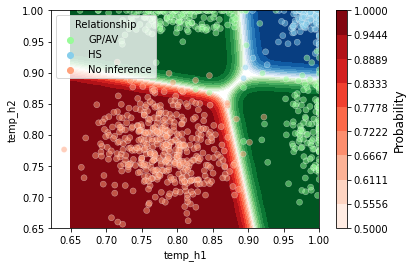

In [64]:
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")
p.add_fam()
p.load_ibd()
p.analyze_ibd(3500, 3500)


In [66]:
famG, ibd, root_nodes = p.get_items()

In [67]:
famG.nodes[('hs1_g2-b1-i1', 'hs1_g2-b2-i1')]

{'id1': 'hs1_g2-b1-i1',
 'id2': 'hs1_g2-b2-i1',
 'rel': 'MHS',
 'k': 1691.0443987704575,
 'data': pedigree_tools.pair_data}

In [68]:
temp = []
couple_inlaw = []
for node, node_data in famG.nodes.items():
    rel = node_data["rel"]
    if rel in ["couple", "inlaws"]:
        node_data = node_data["data"]
        couple_inlaw.append([node, rel, node_data.tot_cov, node_data.tot_all, node_data.n_segs, "sim"])
        continue
    node_data = node_data["data"]
    temp.append([node, rel, node_data.tot_cov, node_data.tot_all, node_data.n_segs, "sim"])
data = pd.DataFrame(temp, columns = ["Pair", "Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"])
couple_inlaw = pd.DataFrame(couple_inlaw, columns = ["Pair", "Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"])

In [69]:
t = couple_inlaw[couple_inlaw.Pair.apply(lambda x: "grandparent67" in x[0])].sort_values("Tot_all")
t

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
1314,"(grandparent67_g1-b1-i1, grandparent67_g1-b1-s1)",couple,241.481809,241.611756,37,sim
1316,"(grandparent67_g1-b1-i1, grandparent67_g2-b1-s1)",inlaws,302.641566,309.095950,45,sim
1315,"(grandparent67_g2-b1-i1, grandparent67_g2-b1-s1)",couple,1044.387623,1108.980201,56,sim
1317,"(grandparent67_g1-b1-s1, grandparent67_g2-b1-s1)",inlaws,1762.075117,1889.956411,61,sim


In [70]:
t = couple_inlaw[couple_inlaw.Pair.apply(lambda x: "grandparent67" in x[0])].sort_values("Tot_all")
t

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
1314,"(grandparent67_g1-b1-i1, grandparent67_g1-b1-s1)",couple,241.481809,241.611756,37,sim
1316,"(grandparent67_g1-b1-i1, grandparent67_g2-b1-s1)",inlaws,302.641566,309.095950,45,sim
1315,"(grandparent67_g2-b1-i1, grandparent67_g2-b1-s1)",couple,1044.387623,1108.980201,56,sim
1317,"(grandparent67_g1-b1-s1, grandparent67_g2-b1-s1)",inlaws,1762.075117,1889.956411,61,sim


In [71]:
data[data["Pair"].apply(lambda x: "grandparent67" in x[0] if not type(x) == float else False)]

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
366,"(grandparent67_g1-b1-i1, grandparent67_g3-b1-i1)",MGP,1493.98294,1570.283431,52,sim


In [72]:
data[data["Pair"].apply(lambda x: "grandparent67" in x[0] if not type(x) == float else False)]

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
366,"(grandparent67_g1-b1-i1, grandparent67_g3-b1-i1)",MGP,1493.98294,1570.283431,52,sim


In [73]:
import itertools as it
def sim_av(z1, z2, z3):
    def ibd_type(gt1, gt2):
        i, j = 0, 0
        if gt1[0] == gt2[0] or gt1[0] == gt2[1]:
            i += 1
        if gt1[1] == gt2[0] or gt1[1] == gt2[1]:
            i += 1
        if gt2[0] == gt1[0] or gt2[0] == gt1[1]:
            j += 1
        if gt2[1] == gt1[0] or gt2[1] == gt1[1]:
            j += 1
        if i == 2 and j == 2:
            return 2
        if i >= 1 or j >= 1:
            return 1
        return 0
    ibd = {"gp1": [0, 0, 0], "gp2": [0, 0, 0], "av": [0, 0, 0], "sib": [0, 0, 0]}
    for _ in range(10000):
        gp1 = [0, 1]
        gp2 = [np.random.choice([0, 1, 2], p = [z1/2, z1/2, 1 - z1]), 3]
        child1 = [np.random.choice(gp1), np.random.choice(gp2)]
        child2 = [np.random.choice(gp1), np.random.choice(gp2)]
        sp = [np.random.choice(gp1 + [4], p = [z2/2, z2/2, 1 - z2]), np.random.choice(gp2 + [5], p = [z3/2, z3/2, 1 - z3])]
        niece = [np.random.choice(sp), np.random.choice(child1)]
        ibd["gp1"][ibd_type(gp1, niece)] += 1
        ibd["gp2"][ibd_type(gp2, niece)] += 1
        ibd["av"][ibd_type(child2, niece)] += 1
        ibd["sib"][ibd_type(child2, child1)] += 1
    for rel, d in ibd.items():
        ibd1 = d[1] / sum(d)
        ibd2 = d[2] / sum(d)
        print(rel, f"IBD1: {ibd1}, IBD2: {ibd2}, IBD cov: {ibd1+ibd2}, Tot IBD: {ibd2*2 + ibd1}")

# .544, 0.575
sim_av(184.770776/3346.298892, 242.314089/3346.298892, 1386.234076/3346.298892)


gp1 IBD1: 0.5177, IBD2: 0.0126, IBD cov: 0.5303, Tot IBD: 0.5429
gp2 IBD1: 0.5672, IBD2: 0.0512, IBD cov: 0.6184000000000001, Tot IBD: 0.6696000000000001
av IBD1: 0.5423, IBD2: 0.0289, IBD cov: 0.5712, Tot IBD: 0.6001
sib IBD1: 0.5198, IBD2: 0.2467, IBD cov: 0.7665000000000001, Tot IBD: 1.0132


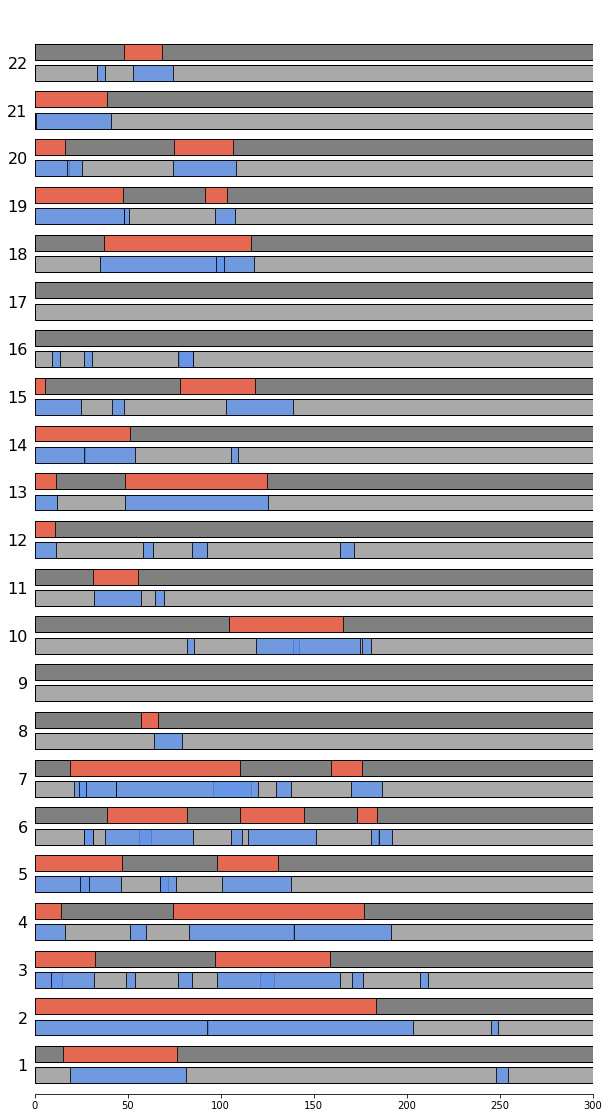

<ipython-input-74-5d7dfb592122>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ibd["hap"] = 0
<ipython-input-74-5d7dfb592122>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)


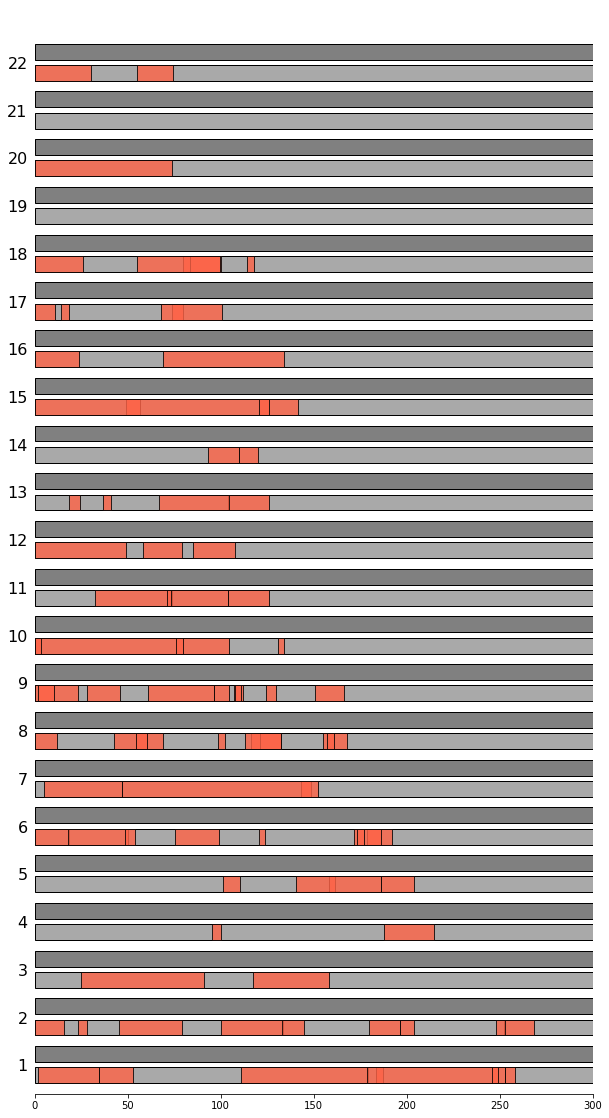

In [74]:
temp_ibd = ibd.get_edge_data("grandparent67_g1-b1-i1", "grandparent67_g3-b1-i1")["ibd"]
k = Karyogram("/Users/cole/Desktop/brown/ponderosa/Untitled/temp.map")
temp_ibd["hap"] = 0
temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)
segs = [[1.0, 15.403812, 76.596144, 1.0], [2.0, 0.0, 183.494403, 1.0], [3.0, 0.0, 32.542726, 1.0], [3.0, 96.901518, 158.524606, 1.0], [4.0, 0.0, 14.047837, 1.0], [4.0, 74.598488, 177.053295, 1.0], [5.0, 0.0, 46.93578, 1.0], [5.0, 98.059777, 130.912321, 1.0], [6.0, 38.801279, 82.10806, 1.0], [6.0, 110.272501, 144.692642, 1.0], [6.0, 173.419295, 183.835697, 1.0], [7.0, 18.989853, 110.171643, 1.0], [7.0, 159.352491, 176.04137, 1.0], [8.0, 57.292064, 66.324767, 1.0], [10.0, 104.453474, 165.630162, 1.0], [11.0, 31.319342, 55.567745, 1.0], [12.0, 0.0, 11.155502, 1.0], [13.0, 0.0, 11.524339, 1.0], [13.0, 48.541884, 125.098764, 1.0], [14.0, 0.0, 51.475446, 1.0], [15.0, 0.0, 5.525096, 1.0], [15.0, 78.27029, 118.431046, 1.0], [18.0, 37.238837, 116.434245, 1.0], [19.0, 0.0, 47.216097, 1.0], [19.0, 91.72944, 103.571793, 1.0], [20.0, 0.0, 16.302364, 1.0], [20.0, 74.893298, 106.796702, 1.0], [21.0, 0.0, 38.662722, 1.0], [22.0, 47.949478, 68.664959, 1.0]]
segs += temp_ibd[["chromosome", "start_cm", "end_cm", "hap"]].values.tolist()
k.plot_segments(segs)
plt.show()

# temp_ibd = ibd.get_edge_data("grandparent67_g1-b1-s1", "grandparent67_g3-b1-i1")["ibd"]
temp_ibd = temp_segs[temp_segs.PAIR_ID == "HMB006_HMB008"]
k = Karyogram("/Users/cole/Desktop/brown/ponderosa/Untitled/temp.map")
temp_ibd["hap"] = 0
temp_ibd["chromosome"] = temp_ibd["chromosome"].apply(int)
k.plot_segments(temp_ibd[["chromosome", "start_cm", "end_cm", "hap"]].values, hap0_color = "tomato")
plt.show()

In [75]:
pair_data = {}
data = data[data.dtype != "real"]
p = PedSims("/Users/cole/Desktop/brown/ponderosa/Untitled/")


for (id1, id2, pair_id), pair_df in himba_segs.groupby(["id1", "id2", "PAIR_ID"]):
    pair_df["l"] = pair_df["end_cm"] - pair_df["start_cm"]
    pair_data[pair_id] = p.pair_segments(id1, id2, pair_df, 1)
    
second_pairs = pairs_df[pairs_df.GTD & (pairs_df.REL.isin(["MHS", "PHS", "MGP", "PGP", "AV"]))].copy()
second_pairs["n_segs"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].n_segs, axis = 1)
second_pairs["Tot_all"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].tot_all, axis = 1)
second_pairs["Tot_cov"] = pairs_df.apply(lambda x: np.nan if x.PAIR_ID not in pair_data else pair_data[x.PAIR_ID].tot_cov, axis = 1)

second_pairs["Rel"] = second_pairs["REL"]


second_pairs["dtype"] = "real"
data = pd.concat([data, second_pairs[["Rel", "Tot_cov", "Tot_all", "n_segs", "dtype"]]])


In [76]:
s = temp_segs[temp_segs.PAIR_ID=="HMB004_HMB005"]
s["l"] = s["end_cm"] - s["start_cm"]
p.pair_segments("HMB004", "HMB005", s).tot_cov

<ipython-input-76-4b0b7babc8a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["l"] = s["end_cm"] - s["start_cm"]


3533.3471111382396

In [77]:
data

,Pair,Rel,Tot_cov,Tot_all,n_segs,dtype
0,"(hs1_g2-b1-i1, hs1_g2-b2-i1)",MHS,1607.948462,1691.044399,60.0,sim
1,"(hs2_g2-b1-i1, hs2_g2-b2-i1)",MHS,2148.579458,2379.438408,57.0,sim
2,"(hs3_g2-b1-i1, hs3_g2-b2-i1)",MHS,1960.245721,2116.628305,59.0,sim
3,"(hs4_g2-b1-i1, hs4_g2-b2-i1)",MHS,1729.640410,1784.133080,59.0,sim
4,"(hs5_g2-b1-i1, hs5_g2-b2-i1)",MHS,2344.470418,2644.534375,58.0,sim
...,...,...,...,...,...,...
5230,NaN,MGP,1791.518875,1891.879864,47.0,real
5233,NaN,MGP,1958.215291,2092.001349,49.0,real
5236,NaN,PGP,2108.241486,2233.447641,45.0,real
5237,NaN,MGP,2189.282833,2306.369262,52.0,real


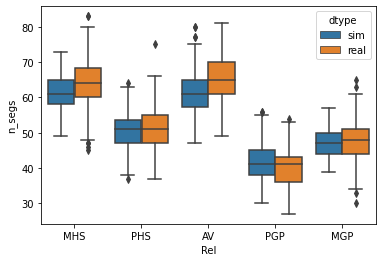

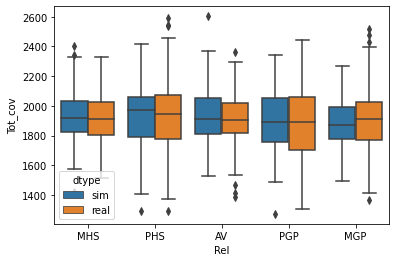

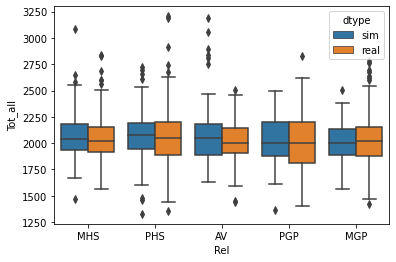

In [78]:
data["k"] = data[["Tot_cov","dtype"]].apply(lambda x: x[0] / (3500 if x[1] == "real" else 2605), axis = 1)

sns.boxplot(data = data, x = "Rel", y = "n_segs", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_cov", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_all", hue = "dtype")
plt.show()



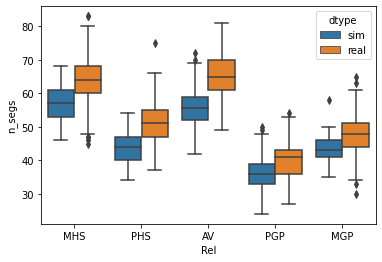

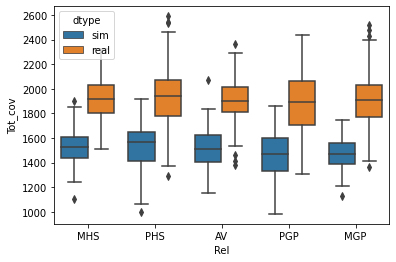

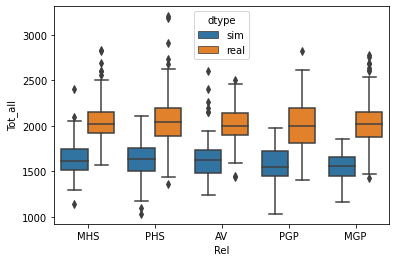

In [37]:
data["k"] = data[["Tot_cov","dtype"]].apply(lambda x: x[0] / (3500 if x[1] == "real" else 2605), axis = 1)

sns.boxplot(data = data, x = "Rel", y = "n_segs", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_cov", hue = "dtype")
plt.show()

sns.boxplot(data = data, x = "Rel", y = "Tot_all", hue = "dtype")
plt.show()



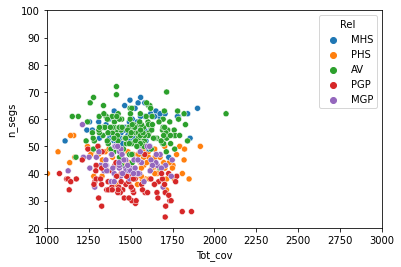

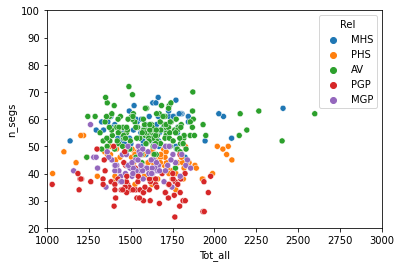

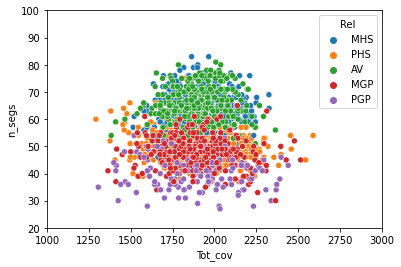

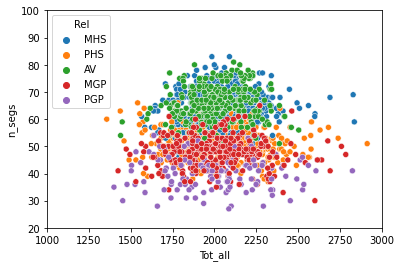

In [29]:
sns.scatterplot(data = data[data.dtype == "sim"], x = "Tot_cov", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "sim"], x = "Tot_all", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "real"], x = "Tot_cov", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

sns.scatterplot(data = data[data.dtype == "real"], x = "Tot_all", y = "n_segs", hue = "Rel")
plt.xlim(1000, 3000)
plt.ylim(20, 100)
plt.show()

In [30]:
second_pairs

,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE,n_segs,Tot_all,Tot_cov,Rel,dtype
0,HMB004_HMB856,HMB004,HMB856,True,0.5086,0.0032,0.2575,2nd,MHS,2nd,69.0,1861.173126,1753.716542,MHS,real
1,HMB004_HMB2970,HMB004,HMB2970,True,0.5057,0.0180,0.2709,2nd,MHS,2nd,59.0,1975.339291,1854.587529,MHS,real
3,HMB005_HMB013,HMB005,HMB013,True,0.5922,0.0177,0.3138,2nd,PHS,2nd,54.0,2384.232410,2212.436771,PHS,real
4,HMB005_HMB1037,HMB005,HMB1037,True,0.5585,0.0072,0.2864,2nd,PHS,2nd,57.0,2157.275433,2002.821201,PHS,real
5,HMB005_HMB1051,HMB005,HMB1051,True,0.5372,0.0085,0.2771,2nd,PHS,2nd,54.0,2073.716844,1868.496928,PHS,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,HMB411_HMB995,HMB995,HMB411,True,0.4881,0.0040,0.2481,2nd,MGP,2nd,47.0,1891.879864,1791.518875,MGP,real
5233,HMB411_HMB997,HMB997,HMB411,True,0.5521,0.0083,0.2843,2nd,MGP,2nd,49.0,2092.001349,1958.215291,MGP,real
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,PGP,2nd,45.0,2233.447641,2108.241486,PGP,real
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,MGP,2nd,52.0,2306.369262,2189.282833,MGP,real


In [31]:
pairs_df = pd.read_csv("/Users/cole/Desktop/brown/ponderosa/Himba_pairs.txt", delim_whitespace = True)
pairs_df[pairs_df.REL == "GP"]



,PAIR_ID,IID1,IID2,GTD,IBD1,IBD2,PIHAT,KINGINF,REL,DEGREE
3722,HMB005_HMB008,HMB005,HMB008,True,0.5531,0.0134,0.2900,2nd,GP,2nd
3725,HMB006_HMB008,HMB006,HMB008,True,0.5106,0.0104,0.2657,2nd,GP,2nd
3729,HMB010_HMB2991,HMB010,HMB2991,True,0.4530,0.0044,0.2309,2nd,GP,2nd
3730,HMB010_HMB095,HMB010,HMB095,True,0.5908,0.0046,0.3000,2nd,GP,2nd
3733,HMB013_HMB2991,HMB013,HMB2991,True,0.5288,0.0115,0.2759,2nd,GP,2nd
...,...,...,...,...,...,...,...,...,...,...
5232,HMB997_Missing019,HMB997,Missing019,False,NaN,NaN,NaN,NaN,GP,2nd
5233,HMB411_HMB997,HMB997,HMB411,True,0.5521,0.0083,0.2843,2nd,GP,2nd
5236,HMB3119_HMB999,HMB999,HMB3119,True,0.5983,0.0065,0.3057,2nd,GP,2nd
5237,HMB060_HMB999,HMB999,HMB060,True,0.6338,0.0090,0.3259,2nd,GP,2nd


In [218]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
from collections import Counter

class PedigreeHierarchy:
    
    def __init__(self):
        
        hier = [["relatives", "1st"],
                ["relatives", "2nd"],
                ["relatives", "3rd"],
                ["relatives", "4th"],
                ["relatives", "MZ"],
                ["1st", "PO"],
                ["1st", "FS"],
                ["2nd", "GP/AV"],
                ["GP/AV", "GP"],
                ["GP", "MGP"],
                ["GP", "PGP"],
                ["2nd", "DCO"],
                ["2nd", "HS"],
                ["HS", "MHS"],
                ["HS", "PHS"],
                ["GP/AV", "AV"],
                ["3rd", "CO"],
                ["3rd", "DHCO"],
                ["3rd", "GGP"],
                ["GGP", "MGGP"],
                ["GGP", "PGGP"],
                ["3rd", "HAV"],
                ["HAV", "MHAV1"],
                ["HAV", "MHAV2"],
                ["HAV", "PHAV1"],
                ["HAV", "PHAV2"],
                ["4th", "HCO"],
                ["HCO", "MHCO"],
                ["HCO", "PHCO"],
                ["4th", "CORM"],
                ["4th", "GGGP"]]
            
        self.hier = nx.DiGraph()

        self.hier.add_nodes_from([(node, {"p": int(node == "relatives"), "p_con": int(node == "relatives"), "method": "None"}) for node in it.chain(*hier)])
        self.hier.add_edges_from(hier)

        self.init_nodes = set(it.chain(*hier))

        print(self.hier.nodes["relatives"])

    ### This set of functions is for holding/managing/plotting the hierarchy for a pair of individuals
    ##################################################################################################

    def add_probs(self, node, **kwargs):
        # a list of probs has been provided, not a single node
        if type(node) == list:
            add_list = node[:]
        # information for a single node has been provided (along with other pos args); convert to a list    
        else:
            add_list = [[node, kwargs["p_con"], kwargs["method"]]]

        # add the new information
        for node, p, method in add_list:
            self.hier.nodes[node]["p_con"] = p
            self.hier.nodes[node]["method"] = method
        
    # after all probabilities have been added, cascade the probabilities down the tree
    def compute_probs(self):
        # iterate through each node in a breadthfirst order
        for parent in nx.bfs_tree(self.hier, "relatives"):

            # get the child nodes of the parent node
            children = nx.descendants_at_distance(self.hier, parent, 1)
            
            # sum the probability of the all the children for rescaling
            p = np.nansum([self.hier.nodes[node]["p_con"] for node in children])

            if p == 0:
                continue
            
            # for each child, rescale the conditional probability and compute the probability by multiply the conditional by the prob of the parent
            for node in children:
                self.hier.nodes[node]["p_con"] /= p
                self.hier.nodes[node]["p"] = self.hier.nodes[node]["p_con"]*self.hier.nodes[parent]["p"]

    # starting at the root, traverses the path of most probable relationships until it reaches a probability below min_p
    def most_probable(self, min_p):
        
        max_node, max_p = "relatives", 1

        while True:

            # iterate through the children and keep track of their probs
            probable_children = [(-1, None)]
            for node in nx.descendants_at_distance(self.hier, max_node, 1):
                probable_children.append([self.hier.nodes[node]["p"], node])

            # sort the children by their probability
            probable_children.sort(key=lambda x: x[0], reverse=True)

            # get the highest prob of the current children
            cur_p = probable_children[0][0]

            # only continue if the current p is greater than the min
            if cur_p < min_p:
                break

            max_p, max_node = probable_children[0]

        return max_node, max_p
 
    # plots the hierarchy and the associated probabilities
    def plot_hierarchy(self, in_g, min_display_p=-1):

        # remove nodes where the prob is below a certain probability
        keep_nodes = [node for node, attr in in_g.nodes(data=True) if attr["p"] > min_display_p]

        print(keep_nodes)
        g = in_g.subgraph(sorted(keep_nodes))

        # get the position of the nodes
        pos = graphviz_layout(g, prog='dot')

        # get max number of nodes per level
        level_size = Counter([y_coord for _,(_, y_coord) in pos.items()])
        max_width = sorted([num for _, num in level_size.items()], reverse=True)[0]

        # set the size of the plot according to the max width of the tree
        f, ax = plt.subplots(figsize=(1.8*max_width, 1.8*max_width))

        # draw the edges
        for i, j in g.edges:
            x1, y1 = pos[i]; x2, y2 = pos[j]
            ax.plot([x1, x2], [y1, y2], color="black", zorder=0)

        # colormap used for choosing the color of the nodes
        cmap = mpl.colormaps['autumn_r'].resampled(8)

        # add the probabilities
        for node, coords in pos.items():
            pos[node] = list(coords) + [g.nodes[node]["p"], g.nodes[node]["p_con"], g.nodes[node]["method"]]

        # plot the nodes and their probabilities
        for lab, (x, y, p, p_con, method) in pos.items():
            ax.text(x, y, lab + f"\n{round(p, 3)}\n{method}\n{round(p_con, 3)}", color="black", va='center', ha='center', 
            bbox=dict(edgecolor=cmap(float(p)), facecolor='white', boxstyle='round'))

        # minor graph aspects
        ax.set_aspect(1)
        ax.axis('off')

    # plots the probability tree for the degree
    def plot_degree(self, show_zero_p):

        g = self.hier.subgraph(nx.descendants_at_distance(self.hier, "relatives", 1) | {"relatives"})

        self.plot_hierarchy(g, -1 if show_zero_p else 0.0)

    # plots the probability tree for second degree relatives
    def plot_second(self, show_zero_p):

        g = self.hier.subgraph(nx.descendants(self.hier, "2nd") | {"2nd"})

        self.plot_hierarchy(g, -1 if show_zero_p else 0.0)

    # plots the entire hierarchy
    def plot_all(self, show_zero_p):

        self.plot_hierarchy(self.hier, -1 if show_zero_p else 0.0)

    ### This set of functions is for holding pairs known relatives
    ##################################################################################################

    # adds a pair of relatives
    def add_pair(self, pair, rel, attrs):
        # add the edge
        self.hier.add_edge(rel, pair)

        # add the pair attributes
        for attr, attr_val in attrs.items():
            self.hier.nodes[pair][attr] = attr_val

    # add pairs from a list of individuals
    def add_pairs_from(self, pair_list):
        for pair, rel, attrs in pair_list:
            self.add_pair(pair, rel, attrs)

    # given a relationship, returns the the relative pairs under that relationship
    def get_pairs(self, node):
        return nx.descendants(self.hier, node) - self.init_nodes
    
    # given a parent node, returns a df with all the descendant nodes and all attributes they have as columns
    def get_pair_df(self, node):

        # get the pairs who are descendant pairs
        pair_list = list(self.get_pairs(node))

        # holds all columns and column values
        columns = {"pair": pair_list,
                   "degree": [nx.shortest_path(self.hier, "relatives", node)[1] for node in pair_list],
                   "rel": [next(self.hier.predecessors(node)) for node in pair_list]}

        # iterate through each person and add
        for index, pair in enumerate(pair_list):
            for attr, val in self.hier.nodes[pair].items():
                # attribute does not exist yet, so add it
                if attr not in columns:
                    columns[attr] = list(np.arange(len(pair_list)) * np.nan)

                # add the attribute
                columns[attr][index] = val

        return pd.DataFrame(columns)

    def get_relative_nodes(self, node, include=False):
        return (nx.descendants(self.hier, node) & self.init_nodes) | ({node} if include else set())

    # given a list of relationship nodes, returns all pairs under
    def get_nodes_from_list(self, node_list):
        return set(it.chain(*[list(self.get_pairs(node)) for node in node_list]))
    

{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
{'p': 1, 'p_con': 1, 'method': 'None'}
['relatives', '1st', '2nd', '3rd', '4th', 'MZ', 'PO', 'FS', 'GP/AV', 'GP', 'MGP', 'PGP', 'DCO', 'HS', 'MHS', 'PHS', 'AV', 'CO', 'DHCO', 'GGP', 'MGGP', 'PGGP', 'HAV', 'MHAV1', 'MHAV2', 'PHAV1', 'PHAV2', 'HCO', 'MHCO', 'PHCO', 'CORM', 'GGGP']


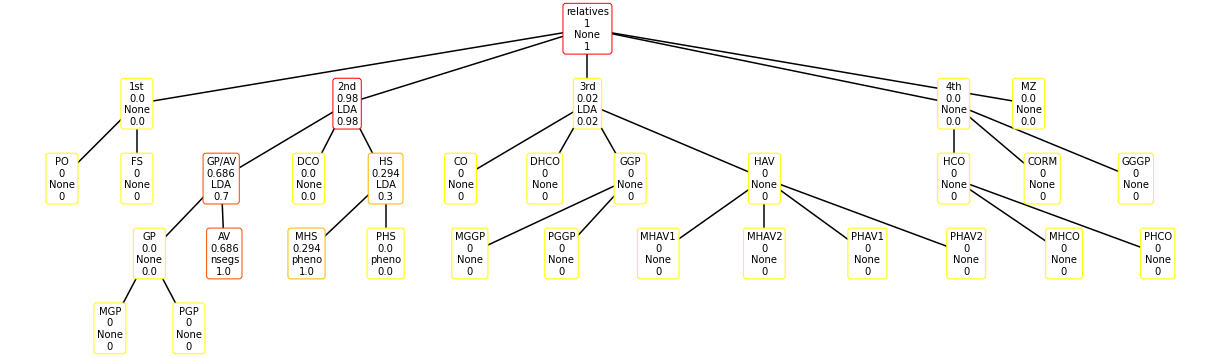

In [219]:
h = PedigreeHierarchy()
print(h.hier.nodes["relatives"])
h.add_probs([("2nd", 0.98, "LDA"), ("3rd", 0.02, "LDA"), ("HS", 0.3, "LDA"), ("PHS", 0, "pheno"), ("MHS", 0.5, "pheno"), ("AV", 0.3, "nsegs"), ("GP/AV", 0.7, "LDA")])
print(h.hier.nodes["relatives"])
h.compute_probs()
print(h.hier.nodes["relatives"])
h.most_probable(0.5)
h.plot_all(True)
# h.plot_degree(False)

In [217]:
h = PedigreeHierarchy()
h.add_pairs_from([[("A", "B"), "PHS", {"ibd1": 0.5, "ibd2": 0.25}], [("A", "C"), "MHS", {"ibd1": 0.49}], [("A", "D"), "CO", {}]])
h.get_nodes_from_list(["MHS", "PHS"])

{'p': 1, 'p_con': 1, 'method': 'None'}


{('A', 'B'), ('A', 'C')}

In [171]:
nx.shortest_path(h.hier, "relatives", "MHS")


['relatives', '2nd', 'HS', 'MHS']

In [14]:
# def plot_tree(g):

#     depth = 0
#     level = ["relatives"]



#     while len(level) > 0:
#         level.sort()
#         print(level)

#         for r, x in zip(level, np.linspace(0, 10, len(level))):
#             plt.text(x, 10-depth, r)

        

#         level = list(it.chain(*[[child for child, l in nx.single_source_shortest_path_length(g, node, 1).items() if l==1] for node in level]))
#         depth += 1


    
# plot_tree(h.hier)

In [10]:
g = nx.DiGraph()
g.add_nodes_from([(1, {"a":1})])
g.add_edges_from([[1,2],[5,4]])

nx.descendants(g, 1)

{2}

[('relatives', {'p': 1, 'p_con': 1}), ('1st', {'p': 0.0, 'p_con': 0.0}), ('2nd', {'p': 0.98, 'p_con': 0.98}), ('3rd', {'p': 0.02, 'p_con': 0.02}), ('4th', {'p': 0.0, 'p_con': 0.0}), ('MZ', {'p': 0.0, 'p_con': 0.0}), ('PO', {'p': 0, 'p_con': 0}), ('FS', {'p': 0, 'p_con': 0}), ('GP/AV', {'p': 0.6859999999999999, 'p_con': 0.7}), ('GP', {'p': 0.4801999999999999, 'p_con': 0.7}), ('MGP', {'p': 0.04801999999999999, 'p_con': 0.1}), ('PGP', {'p': 0.4321799999999999, 'p_con': 0.9}), ('DCO', {'p': 0.0, 'p_con': 0.0}), ('HS', {'p': 0.294, 'p_con': 0.3}), ('MHS', {'p': 0.294, 'p_con': 1.0}), ('PHS', {'p': 0.0, 'p_con': 0.0}), ('AV', {'p': 0.20579999999999998, 'p_con': 0.3}), ('CO', {'p': 0, 'p_con': 0}), ('DHCO', {'p': 0, 'p_con': 0}), ('GGP', {'p': 0, 'p_con': 0}), ('MGGP', {'p': 0, 'p_con': 0}), ('PGGP', {'p': 0, 'p_con': 0}), ('HAV', {'p': 0, 'p_con': 0}), ('MHAV1', {'p': 0, 'p_con': 0}), ('MHAV2', {'p': 0, 'p_con': 0}), ('PHAV1', {'p': 0, 'p_con': 0}), ('PHAV2', {'p': 0, 'p_con': 0}), ('HCO', {

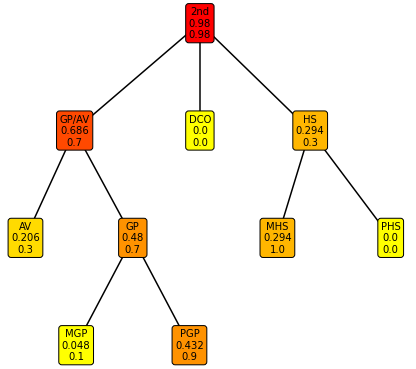

In [77]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
from collections import Counter

g = h.hier.copy()


def plot_hierarchy(in_g, min_display_p=-1):

    # remove nodes where the prob is below a certain probability
    keep_nodes = [node for node, attr in in_g.nodes(data=True) if attr["p"] > min_display_p]
    g = in_g.subgraph(keep_nodes)

    # get the position of the nodes
    pos = graphviz_layout(g.subgraph(keep_nodes), prog='dot')

    # get max number of nodes per level
    level_size = Counter([y_coord for _,(_, y_coord) in pos.items()])
    max_width = sorted([num for _, num in level_size.items()], reverse=True)[0]

    # set the size of the plot according to the max width of the tree
    f, ax = plt.subplots(figsize=(1.8*max_width, 1.8*max_width))

    # draw the edges
    for i, j in g.edges:
        x1, y1 = pos[i]; x2, y2 = pos[j]
        ax.plot([x1, x2], [y1, y2], color="black", zorder=0)

    # colormap used for choosing the color of the nodes
    cmap = mpl.colormaps['autumn_r'].resampled(8)

    # add the probabilities
    for node, coords in pos.items():
        print(g.nodes[node])
        pos[node] = list(coords) + [g.nodes[node]["p"], g.nodes[node]["p_con"]]

    # plot the nodes and their probabilities
    for lab, (x, y, p, p_con) in pos.items():
        ax.text(x, y, lab + f"\n{round(p, 3)}\n{round(p_con, 3)}", color="black", va='center', ha='center', 
        bbox=dict(facecolor=cmap(float(p)), edgecolor='black', boxstyle='round'))

    # minor graph aspects
    ax.set_aspect(1)
    ax.axis('off')

h = PedigreeHierarchy()
h.hier.nodes(data=True)
h.add_probs([("2nd", 0.98), ("3rd", 0.02), ("HS", 0.3), ("PHS", 0), ("MHS", 0.5), ("AV", 0.3), ("GP/AV", 0.7), ("GP", 0.7), ("MGP", 0.1), ("PGP", 0.9)])
h.compute_probs()
h.hier.nodes(data=True)

g = h.hier.copy()
print(g.nodes(data=True))
plot_hierarchy(g.subgraph(nx.descendants(g, "2nd") | {"2nd"}))


In [36]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

viridis = mpl.colormaps['autumn_r'].resampled(8)

In [78]:
pair_df = pd.read_csv("../PedigreeSimulations/SA_sims/av/segments.txt", delim_whitespace=True)
pair_df



,"chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,new,fid1,fid2,rel,degree,iteration"
0,"1,av52_g2-b1-i1,av52_g2-b2-i1,0,0,0,529,0.0722..."
1,"1,av93_g2-b1-i1,av93_g2-b2-i1,0,0,77,492,0.485..."
2,"1,av90_g3-b1-i1,av90_g4-b1-i1,0,1,0,1029,0.072..."
3,"1,av132_g2-b1-i1,av132_g2-b2-i1,1,1,293,613,2...."
4,"1,av42_g2-b1-i1,av42_g2-b2-i1,1,1,0,795,0.0722..."
...,...
52216,"22,av205_g2-b2-i1,av205_g3-b1-i1,1,0,1189,1888..."
52217,"22,av205_g3-b1-i1,av205_g3-b2-i1,0,0,1945,5247..."
52218,"22,av205_g3-b1-i1,av205_g4-b1-i1,0,1,3456,7801..."
52219,"22,av205_g3-b1-i1,av205_g4-b1-i1,1,1,0,3508,0...."


In [15]:
pair_df = pd.read_csv("../PedigreeSimulations/Himba2nd_sims/av/segments.txt", sep=" ")


pair_df["l"] = pair_df.end_cm - pair_df.start_cm

pair_df = pd.concat([tmp for _, tmp in pair_df.groupby(["id1", "id2"]) if tmp["l"].sum() < 2000])

pair_df = pair_df[pair_df.rel=="AV"]
pair_df

,chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,fid1,fid2,rel,degree,l
34007,1,av102_g2-b2-i1,av102_g3-b1-i1,0,1,8017,11970,84.323986,117.795538,59321745,90537317,av102,av102,AV,2nd,33.471552
34160,1,av102_g2-b2-i1,av102_g3-b1-i1,1,1,965,2189,13.377241,28.759669,6232157,14880751,av102,av102,AV,2nd,15.382428
34822,1,av102_g2-b2-i1,av102_g3-b1-i1,0,0,19454,20779,186.133032,196.786030,177629723,189587034,av102,av102,AV,2nd,10.652998
34898,1,av102_g2-b2-i1,av102_g3-b1-i1,0,1,18594,20117,179.489700,191.679460,169498975,183159377,av102,av102,AV,2nd,12.189760
35954,1,av102_g2-b2-i1,av102_g3-b1-i1,0,0,28679,29109,270.689200,275.872628,244877955,246988179,av102,av102,AV,2nd,5.183428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69093,20,av98_g2-b2-i1,av98_g3-b1-i1,1,0,6222,6554,67.609026,71.239242,45244846,46947639,av98,av98,AV,2nd,3.630216
69841,21,av98_g2-b2-i1,av98_g3-b1-i1,0,0,0,4448,0.703245,53.565956,14669931,43444731,av98,av98,AV,2nd,52.862710
70035,22,av98_g2-b2-i1,av98_g3-b1-i1,0,0,0,787,0.948961,15.991643,17119450,22861994,av98,av98,AV,2nd,15.042682
70549,22,av98_g2-b2-i1,av98_g3-b1-i1,0,0,1119,4556,21.970017,60.923075,25612701,47447370,av98,av98,AV,2nd,38.953059


In [16]:
import pickle as pkl
def keep_ibd_regions(pair_df, regions, id_label, inter_phase=False):

    regions = pd.DataFrame(regions, columns=["chromosome", "start", "stop"])

    # stores the new ibd segments
    new_segments = []

    # iterate through each chromosome
    for chrom, chrom_df in pair_df.groupby("chromosome"):

        # only take regions from the chromosome
        chrom_region = regions[regions.chromosome==chrom]

        if chrom_region.shape[0] == 0:
            continue

        # iterate through each segment
        for _, row in chrom_df.iterrows():

            start1, stop1 = row["start_cm"], row["end_cm"]
            

            # now iterate through the coverage regions
            for start2, stop2 in chrom_region[["start", "stop"]].values:
                # there is overlap
                if min(stop1, stop2) - max(start1, start2) > 0:
                    # adjust the stop/stop coordinates
                    new_start = start1 if start2 < start2 else start2
                    new_stop = stop1 if stop2 > stop1 else stop2

                    new_segments.append([chrom, row["id1"], row["id2"], row["id1_haplotype"], row["id2_haplotype"], new_start, new_stop,])

    new_segments = pd.DataFrame(new_segments, columns=["chromosome", "id1", "id2", "id1_haplotype", "id2_haplotype", "start_cm", "end_cm"])
    new_segments["l"] = new_segments.end_cm - new_segments.start_cm

    # now compute the haplotype scores
    tot = new_segments["l"].sum()

    if inter_phase:
        h1 = new_segments[new_segments[f"{id_label}_haplotype"]==0]["l"].sum() / tot if tot > 0 else np.nan

    else:
        h1 = sum([max(chrom_df[chrom_df[f"{id_label}_haplotype"]==0]["l"].sum(), chrom_df[chrom_df[f"{id_label}_haplotype"]==1]["l"].sum()) for _, chrom_df in new_segments.groupby("chromosome")]) / tot if tot > 0 else np.nan

    return h1 if h1 > 0.5 else 1-h1

i = open("relative_phased/regions.pkl", "rb")
d = pkl.load(i)


data = []
for pair, tmp in pair_df.groupby(["id1", "id2"]):
    for id_lab in ["id1", "id2"]:
        data.append([pair, id_lab, "chr1", False, keep_ibd_regions(tmp[tmp.chromosome==1], [[1, 0, 300]], id_lab, False)])
        for p in [True, False]:
            data.append([pair, id_lab, "all", p, keep_ibd_regions(tmp, [[i, 0, 300] for i in range(1, 23)], id_lab, p)])
            for r in ["hs", "co", "hco"]:
                range_list = d[r][np.random.choice(len(d[r]))]
                data.append([pair, id_lab, r, p, keep_ibd_regions(tmp, range_list, id_lab, p)])

    

hap_scores = pd.DataFrame(data, columns=["pair", "id_lab", "rel", "inter_phased", "h1"])

In [87]:
np.random.choice(len(d["co"]))




154

In [68]:
pair = hap_scores[hap_scores.apply(lambda x: x.h1 < 0.7 and x.id_lab=="id2", axis=1)].pair.values[0]

pair_df[pair_df.apply(lambda x: (x.id1, x.id2) == pair, axis=1)]["l"].sum()

3686.4935075185767

/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

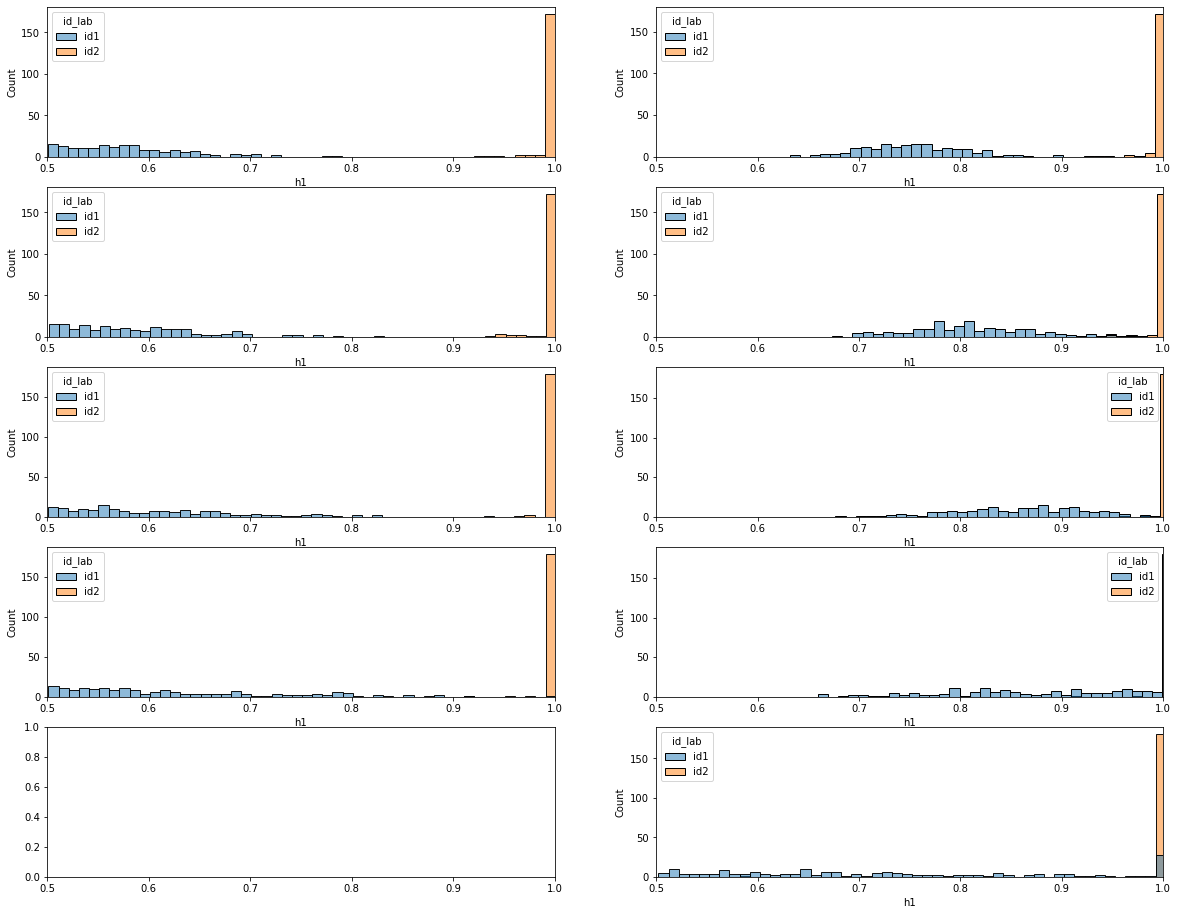

In [81]:
f, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 16))

for (r, inter), ax in zip(it.product(["all", "hs", "co", "hco", "chr1"], [True, False]), axs.flat):
    
    
    sns.histplot(data=hap_scores[hap_scores.apply(lambda x: x.rel==r and x.inter_phased==inter, axis=1)], x="h1", ax=ax, hue="id_lab", binwidth=0.01)
    ax.title(f"{r} inter={inter}")

    ax.set_xlim(0.5, 1)

In [12]:

data = []
import time
t = time.time()
for rel in ["MGP", "PHS"]:
    i = 0
    pair_df = pd.read_csv(f"../PedigreeSimulations/Himba2nd_sims/{rel.lower()}/segments.txt", sep=" ")
    for pair, tmp in pair_df[pair_df.rel==rel].groupby(["id1", "id2"]):
        tmp = tmp[tmp.chromosome>=1]
        p = ProcessSegments(tmp)
        d = p.ponderosa_data(3500, inter_phase=False)
        data.append((d.ibd1, d.ibd2, d.h1, d.h2, rel))
        i += 1
    print(i, time.time()-t)

# t = time.time()
# i = 0
# pair_df = pd.read_csv("../PedigreeSimulations/Himba_sims/mhs/segments.txt", sep=" ")
# for pair, tmp in pair_df[pair_df.rel=="MHS"].groupby(["id1", "id2"]):
#     tmp = tmp[tmp.chromosome>=1]
#     p = ProcessSegments(tmp)
#     d = p.ponderosa_data(3500, inter_phase=True)
#     data.append((d.ibd1, d.ibd2, d.h1, d.h2, "MHS"))
#     i += 1
# print(i, time.time()-t)

df = pd.DataFrame(data, columns=["ibd1", "ibd2", "h1", "h2", "PHS"])

234 4.548284530639648
141 7.015722274780273


In [6]:
df[["ibd1", "ibd2"]].mean()

ibd1    0.533392
ibd2    0.010688
dtype: float64

/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/cwilli50/.conda/envs/msp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

(0.5, 1.0)

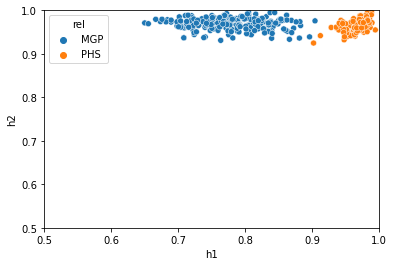

In [13]:
sns.scatterplot(data=pd.DataFrame(data, columns=["ibd1", "ibd2", "h1", "h2", "rel"]), x="h1", y="h2", hue="rel")
plt.xlim(0.5, 1)
plt.ylim(0.5, 1)

In [234]:
pair_df[pair_df.apply(lambda x: x.id1=="av1_g2-b2-i1" and x.id2=="av1_g3-b1-i1", axis=1)]

,chromosome,id1,id2,id1_haplotype,id2_haplotype,start,end,start_cm,end_cm,start_bp,end_bp,new,fid1,fid2,rel,degree,iteration
0,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,0,685,6.670000e-02,5.721359,752721,3575146,0,av1,av1,AV,2nd,1
27,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,4282,8477,3.646070e+01,64.928755,18565761,39061771,0,av1,av1,AV,2nd,1
66,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,2436,4355,2.080636e+01,37.306800,10978767,18789789,0,av1,av1,AV,2nd,1
74,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,10714,11213,7.516810e+01,79.010300,53477526,55486064,0,av1,av1,AV,2nd,1
182,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,18651,21760,1.255534e+02,145.510326,99484386,117514880,0,av1,av1,AV,2nd,1
227,1,av1_g2-b2-i1,av1_g3-b1-i1,0,1,38065,41641,2.449521e+02,278.046766,233329679,249168530,0,av1,av1,AV,2nd,1
228,1,av1_g2-b2-i1,av1_g3-b1-i1,1,1,21688,23591,1.446759e+02,157.436282,117025609,154700096,0,av1,av1,AV,2nd,1
548,2,av1_g2-b2-i1,av1_g3-b1-i1,0,1,7164,19574,5.405367e+01,128.592500,34238100,115275531,0,av1,av1,AV,2nd,1
549,2,av1_g2-b2-i1,av1_g3-b1-i1,1,1,20701,29643,1.353776e+02,189.862400,121919116,180460930,0,av1,av1,AV,2nd,1
802,3,av1_g2-b2-i1,av1_g3-b1-i1,1,1,23238,24069,1.454003e+02,149.859385,133589324,139092863,0,av1,av1,AV,2nd,1


In [ ]:
import yaml

i = open("relationship_codes.yaml", "r")
y = yaml.safe_open(i)

In [ ]:
'''
Requires a pedigree hierarchy file where pairs have the following attributes:
1. IBD1
2. IBD2
3. n
4. h1, h2
'''

def train_classifiers(pairs, outfile):

    ### Train the degree classifier
    degree_data = pairs.get_pair_df_from(pairs.degree_nodes)

    degree = LinearDiscriminantAnalysis().fit(degree_data[["ibd1", "ibd2"]].values, degree_data[["degree"]].values)

    ### Train the nsegs classifier
    segs_data = pairs.get_pair_df_from(["MGP", "PGP", "AV", "MHS", "PHS"])
    segs_data["k"] = segs_data.apply(lambda x: x.ibd1/2 + x.ibd2, axis=1)

    n_segs = LinearDiscriminantAnalysis().fit(segs_data[["k", "n"]].values, segs_data["rel"])

    ### Train the haplotype score classifier
    haps_data = pairs.get


    for degree in pairs.hier.successors("relatives"):


    # def plot(xs, ys, classif, lab, xlab, ylab):

    training_data = pd.read_csv(training_data)

    # train the degree classifier
    degree = LinearDiscriminantAnalysis().fit(training_data[["ibd1", "ibd2", "n_ibd2"]].values, training_data["degree"].values)

    # subset the second degree relatives
    second = training_data[training_data.degree=="2nd"]

    # get the nsegs classifier
    n_segs = LinearDiscriminantAnalysis().fit(second[["ibd1", "n"]].values, second["rel"].values)

    # get the hap classifier
    hs = second[second["rel"].apply(lambda x: "HS" in x)]
    gpav = second[second["rel"].apply(lambda x: x == "AV" or "GP" in x)]
    phase_error = pd.DataFrame([[np.random.uniform(0.5,1), np.random.uniform(0.5,1)] for _ in range(100)], columns=["h1", "h2"])

    hs["lab"] = "HS"
    gpav["lab"] = "GPAV"
    phase_error["lab"] = "Phase Error"

    if hs.shape[0] == 0 or gpav.shape[0] == 0:
        print("None of one of: HS, GP, AV")
        return

    min_n = min(hs.shape[0], gpav.shape[0])

    hap_df = pd.concat([hs.sample(min_n), gpav.sample(min_n), phase_error])

    hap = LinearDiscriminantAnalysis().fit([sorted(i) for i in hap_df[["h1", "h2"]].values], hap_df["lab"].values)

    for classif, lab in zip([degree, hap, n_segs], ["degree", "hap", "nsegs"]):

        i = open(outfile.replace("degree", lab), "wb")
        pkl.dump(classif, i)
        i.close()

In [29]:
i = open("/Users/cwilli50/Downloads/bags_wgs_all_samples.pkl", "rb")
obj = pkl.load(i)
g = obj.g.copy()

In [30]:
for node, data in list(g.nodes(data=True)):
    for parent in ["mother", "father"]:
        p = data[parent]
        if p == -1:
            continue
        if p not in g.nodes:
            g.add_node(p, sex="1" if parent == "father" else "2", father=-1, mother=-1, age=np.nan, popl="pop1")
            print(p, "1" if parent == "father" else "2")


15001015 1
15001017 2
15001018 1
15002016 2
15002017 1
15002047 1
15002023 2
15532055 2
15532050 1
15532361 1
15532008 1
15532053 2
15532052 1
15532059 1
15532058 1
15532017 2
15532060 1
15003011 1
15003016 2
15003017 1
15003034 1
15003033 1
15003023 1
15003009 1
15003026 2
15003032 1
15004064 1
15004026 2
15004027 1
15004028 1
15004029 2
15004063 1
15004011 2
15004015 1
15004010 2
15004048 1
15004035 1
15004036 2
15004041 1
15004039 1
15004040 1
15004049 2
15004050 1
15004051 2
15004052 1
15006007 1
15006008 1
15006050 1
15006038 1
15006044 1
15006045 1
15006047 1
15006046 1
15008001 2
15008002 1
15008003 2
15008008 1
15009029 1
15009006 2
15009007 1
15009027 1
15009050 1
15009016 1
15009020 1
15009026 1
15009033 2
15009005 2
15009037 1
15011006 2
15011007 1
15011008 2
15011032 1
15137003 2
15011501 2
15011500 1
15012121 1
15012011 1
15012013 2
15012122 1
15012027 1
15012123 1
15012014 1
15012055 2
15012061 1
15014005 2
15014006 1
15014039 2
15014040 1
15014051 2
15014052 1
15014054 1

In [31]:
obj.g = g
pedigree = Pedigree(samples=obj, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pedigree.find_all_relationships()

In [36]:
PONDEROSA(obj)